## 라이브러리

In [126]:
import os
import time
import copy
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import torch
import torch_sparse
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from torch.nn import Linear
import torch.optim as optim
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import wasserstein_distance, pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy, ks_2samp, cramervonmises_2samp, wasserstein_distance
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, average_precision_score


from typing import Optional, Tuple
from torch_sparse import SparseTensor, matmul
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# import dgl
# from dgl.nn.pytorch import GraphConv

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 함수

In [48]:
# 모델 관련 함수

class GCN_Body(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GCN_Body, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nhid)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = self.dropout(x)
        x = self.gc2(x, edge_index)
        return x  
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid,nclass)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = self.fc(x)
        return x

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().clamp(min=1)
        norm = 1.0 / deg[row].sqrt() / deg[col].sqrt()
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return self.linear(out)
    
# 나중에 수정 필요함
class GAT_body(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT_body, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = F.elu
        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_hidden, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))
    
    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)

        return logits

class GAT(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()

        self.body = GAT_body(num_layers, in_dim, num_hidden, heads, feat_drop, attn_drop, negative_slope, residual)
        self.fc = nn.Linear(num_hidden,num_classes)
    
    def forward(self, g, inputs):
        logits = self.body(g,inputs)
        logits = self.fc(logits)

        return logits

def get_model(model, nfeat,
              num_hidden=64, dropout=0.5, num_heads=1, num_layers=1, num_out_heads=1, attn_drop=0.0, negative_slope=0.2, residual=False):
    if model == "GCN":
        model = GCN_Body(nfeat, num_hidden, dropout)
    elif model == "GAT":
        heads = ([num_heads] * num_layers) + [num_out_heads]
        model = GAT_body(num_layers, nfeat, num_hidden, heads, dropout, attn_drop, negative_slope, residual)
    else:
        raise ValueError("Model not implemented")
    return model
   
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]

    return 2*(features - min_values).div(max_values-min_values) - 1

def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

def get_sen(sens, idx_sens_train):
    num_classes = 2  # binary sensitive attribute assumed
    one_hot = F.one_hot(sens.long(), num_classes=num_classes).float()  # (N, 2)

    # training 노드에 대해서만 정규화
    group_sums = one_hot[idx_sens_train].sum(dim=0, keepdim=True)  # (1, 2)
    group_sums[group_sums == 0] = 1  # 0으로 나누는 것 방지

    one_hot[idx_sens_train] = one_hot[idx_sens_train] / group_sums  # group-normalized

    return one_hot  # shape: (N, 2)

# def get_sen(sens, idx_sens_train):
#     sens_zeros = torch.zeros_like(sens)
#     sens_1 = sens 
#     sens_0 = (1 - sens) 
    
#     sens_1[idx_sens_train] = sens_1[idx_sens_train] / len(sens_1[idx_sens_train])
#     sens_0[idx_sens_train] = sens_0[idx_sens_train] / len(sens_0[idx_sens_train])

#     sens_zeros[idx_sens_train] = sens_1[idx_sens_train] - sens_0[idx_sens_train]
#     sen_mat = torch.unsqueeze(sens_zeros, dim=0)
#     return sen_mat

# def check_sen(edge_index, sen):
#     nnz = edge_index.nnz()
#     deg = torch.eye(edge_index.sizes()[0]).cuda()
#     adj = edge_index.to_dense()
#     lap = (sen.t() @ sen).to_dense()
#     lap2 = deg - adj
#     diff = torch.sum(torch.abs(lap2-lap)) / nnz
#     assert diff < 0.000001, f'error: {diff} need to make sure L=B^TB'


In [138]:
# 데이터셋 로드 함수

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def load_dataset(dataset, sens_attr,predict_attr, path="./dataset/pokec/", 
               label_number=1000, sens_number=500, test_idx=False, seed=1127):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    
    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}

    # edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)
    edges_unordered = np.genfromtxt(os.path.join(path, f"{dataset}_relationship.txt"), dtype=np.int64)

    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=int).reshape(edges_unordered.shape)
    mapped_edges = []
    dropped = 0
    for u, v in edges_unordered:
        u_mapped = idx_map.get(u)
        v_mapped = idx_map.get(v)
        if u_mapped is not None and v_mapped is not None:
            mapped_edges.append((u_mapped, v_mapped))
        else:
            dropped += 1

    print(f"[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: {dropped}")
    edges = np.array(mapped_edges, dtype=int)

    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    
    random.seed(seed)
    label_idx = np.where(labels>=0)[0]

    # random.shuffle(label_idx)
    # idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    # idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    # if test_idx:
    #     idx_test = label_idx[label_number:]
    #     idx_val = idx_test
    # else:
    #     idx_test = label_idx[int(0.75 * len(label_idx)):]

    # sens = idx_features_labels[sens_attr].values
    # sens_idx = set(np.where(sens >= 0)[0])
    # idx_test = np.asarray(list(sens_idx & set(idx_test)))
    # sens = torch.FloatTensor(sens)
    # idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    # random.seed(seed)
    # random.shuffle(idx_sens_train)
    # idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

    # idx_train = torch.LongTensor(idx_train)
    # idx_val = torch.LongTensor(idx_val)
    # idx_test = torch.LongTensor(idx_test)

    # stratified sampling
    sens_all = idx_features_labels[sens_attr].values
    labels_all = labels  # np.ndarray 혹은 torch.Tensor

    # 유효한 인덱스 (라벨, 민감 속성 모두 존재)
    valid_idx = np.where((labels_all >= 0) & (sens_all >= 0))[0]
    sens_valid = sens_all[valid_idx]

    # Stratified Split: Train (50%) / Temp (50%)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
    train_part, temp_part = next(sss1.split(valid_idx, sens_valid))

    # Stratified Split: Val (25%) / Test (25%)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
    val_part, test_part = next(sss2.split(temp_part, sens_valid[temp_part]))

    # 인덱스 최종화
    idx_train = torch.LongTensor(valid_idx[train_part])
    idx_val = torch.LongTensor(valid_idx[temp_part[val_part]])
    idx_test = torch.LongTensor(valid_idx[temp_part[test_part]])

    # 민감 속성 텐서
    sens = torch.FloatTensor(sens_all)

    # sens 학습 인덱스: val/test와 겹치지 않게 선택
    sens_idx = set(np.where(sens_all >= 0)[0])
    idx_sens_train_pool = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
    random.seed(seed)
    random.shuffle(idx_sens_train_pool)
    idx_sens_train = torch.LongTensor(idx_sens_train_pool[:sens_number])
    
    # random.shuffle(sens_idx)

    if dataset == 'nba':
        features = feature_norm(features)

    return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train

def is_symmetric(m):
    '''
    Judge whether the matrix is symmetric or not.
    :param m: Adjacency matrix(Array)
    '''
    res = np.int64(np.triu(m).T == np.tril(m))
    # if np.where(res==0)[0] != []:
    if np.where(res == 0)[0].size > 0:
        raise ValueError("The matrix is not symmetric!")
    else:
        pass
    
def symetric_normalize(m, half: bool):
    '''
    Symmetrically normalization for adjacency matrix
    :param m: (Array) Adjacency matrix
    :param half: (bool) whether m is triu or full
    :return: (Array) An symmetric adjacency matrix
    '''
    if not half:
        is_symmetric(m)
    else:
        m = m + m.T - np.diag(np.diagonal(m))

    hat_m = m + np.eye(m.shape[0])
    D = np.sum(hat_m, axis=1)
    D = np.diag(D)

    # D = np.power(D, -0.5)
    with np.errstate(divide='ignore'):
        D = np.power(D, -0.5)
        D[np.isinf(D)] = 0

    D[np.isinf(D)] = 0
    sn_m = np.matmul(np.matmul(D, hat_m), D)
    return sn_m

def sp2sptensor(m):
    # sparse_m = sp.coo_matrix(m).astype(np.float)
    sparse_m = sp.coo_matrix(m).astype(np.float64)
    # indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col)).astype(int))
    indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col))).long()
    values = torch.from_numpy(sparse_m.data)
    shape = torch.Size(sparse_m.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

class German:
    def __init__(self, path):
        if not os.path.exists(path):
            raise ValueError("Data path doesn't exist!")
        else:
            self.data_path = path
        self.raw_data = self._node_process()
        self.A_tensor, self.A = self._edge_process()
        self.senIdx, self.sen_vals, self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor, self.features, self.labels = self._split_data()

    def _node_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.csv':
                continue
            else:
                df_data = pd.read_csv(os.path.join(self.data_path, file))

                # modify str feature
                # df_data['GoodCustomer'].replace(-1, 0, inplace=True)
                df_data['GoodCustomer'] = df_data['GoodCustomer'].replace(-1, 0).astype(int)

                # df_data['Gender'].replace('Male', 1, inplace=True)
                # df_data['Gender'].replace('Female', 0, inplace=True)
                gender_map = {'Female': 0, 'Male': 1}
                df_data['Gender'] = df_data['Gender'].map(gender_map).astype(int)

                purposeList = list(df_data['PurposeOfLoan'])
                random.shuffle(purposeList)
                purposeDict = {}
                index = 0
                for pur in purposeList:
                    if purposeDict.get(pur, None) is None:
                        purposeDict[pur] = index
                        index += 1
                    else:
                        continue

                for key in purposeDict.keys():
                    # df_data['PurposeOfLoan'].replace(key, purposeDict[key], inplace=True)
                    df_data['PurposeOfLoan'] = df_data['PurposeOfLoan'].map(purposeDict).fillna(-1).astype(int)
                    
                return df_data

    def _edge_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.txt':
                continue
            else:
                edges = np.loadtxt(os.path.join(self.data_path, file)).astype(int)

                # Adjacency
                num_dim = len(self.raw_data)
                A = np.zeros((num_dim, num_dim))
                for i in range(len(edges)):
                    A[edges[i][0]][edges[i][1]] = 1
                    A[edges[i][1]][edges[i][0]] = 1
                sym_norm_A = symetric_normalize(A, half=False)
                syn_norm_A_tensor = sp2sptensor(sym_norm_A)
                return syn_norm_A_tensor, A

    def _split_data(self):
        pos_data = self.raw_data[self.raw_data['GoodCustomer']==1]
        pos_index = list(pos_data.index)
        neg_data = self.raw_data[self.raw_data['GoodCustomer']==0]
        neg_index = list(neg_data.index)

        # shuffle the index
        random.seed(20)
        random.shuffle(pos_index)
        random.shuffle(neg_index)

        # split the data
        train_pos_idx = pos_index[:int(0.5*len(pos_index))]
        train_neg_idx = neg_index[:int(0.5*len(neg_index))]
        val_pos_idx = pos_index[int(0.5*len(pos_index)): int(0.75*len(pos_index))]
        val_neg_idx = neg_index[int(0.5*len(neg_index)): int(0.75*len(neg_index))]
        test_pos_idx = pos_index[int(0.75*len(pos_index)):]
        test_neg_idx = neg_index[int(0.75*len(neg_index)):]

        trainIdx = train_pos_idx + train_neg_idx
        random.shuffle(trainIdx)
        valIdx = val_pos_idx + val_neg_idx
        random.shuffle(valIdx)
        testIdx = test_pos_idx + test_neg_idx
        random.shuffle(testIdx)

        assert len(trainIdx)+len(valIdx)+len(testIdx) == len(self.raw_data), "Missing data or leaking data!"

        feature_cols = list(self.raw_data.columns)
        feature_cols.remove('GoodCustomer')
        sen_idx = feature_cols.index('Gender')
        sen_vals = self.raw_data['Gender'].values.astype(int)
        feature_data = self.raw_data[feature_cols]
        labels = self.raw_data['GoodCustomer']

        # transform to tensor
        trainIdxTensor = torch.LongTensor(trainIdx)
        valIdxTensor = torch.LongTensor(valIdx)
        testIdxTensor = torch.LongTensor(testIdx)
        featuredata = torch.FloatTensor(np.array(feature_data))
        labels = torch.LongTensor(np.array(labels))

        return sen_idx, sen_vals, trainIdxTensor, valIdxTensor, testIdxTensor, featuredata, labels

    def get_index(self):
        return [self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor]

    def get_raw_data(self):
        return [self.features, self.A_tensor, self.labels]

    def generate_counterfactual_perturbation(self, data):
        '''
        Generate counterfactual data by flipping sensitive attribute.
        :param data: Tensor
        :return: counterfactual data
        '''
        feature_data = copy.deepcopy(data)
        feature_data[:, self.senIdx] = 1 - feature_data[:, self.senIdx]
        return feature_data

    def generate_node_perturbation(self, prob: float, sen: bool = False):
        '''
        Perturbing node attributes, except for sensitive attributes.
        :param prob: portion of perturbed data
        :return: perturbed data
        '''
        feature_data = copy.deepcopy(self.features)
        r = np.random.binomial(n=1, p=prob, size=feature_data.numpy().shape)
        for i in range(len(feature_data)):
            r[i][self.senIdx] = 0
        noise = np.multiply(r, np.random.normal(0., 1., r.shape))
        noise_tensor = torch.FloatTensor(noise)
        x_hat = feature_data + noise_tensor

        if sen:
            x_hat = self.generate_counterfactual_perturbation(x_hat)
        return x_hat

    def generate_struc_perturbation(self, drop_prob: float, tensor: bool = True):
        A = copy.deepcopy(self.A)
        half_A = np.triu(A)
        row, col = np.nonzero(half_A)
        idx_perturb = np.random.binomial(n=1, p=1-drop_prob, size=row.shape)
        broken_edges = np.where(idx_perturb==0)[0]
        for idx in broken_edges:
            half_A[row[idx]][col[idx]] = 0
        new_A = symetric_normalize(half_A, half=True)
        if tensor:
            new_A = sp2sptensor(new_A)
        return new_A

def load_dataset_unified(dataset, sens_attr, predict_attr, path="./dataset/", 
                         label_number=1000, sens_number=500, test_idx=False, seed=1127):
    
    if dataset.lower() != 'german':
        full_path = path
        return load_dataset(dataset, sens_attr, predict_attr, full_path, label_number, sens_number, test_idx, seed)

    elif dataset.lower() == 'german':
        full_path = path
        print('Loading {} dataset from {}'.format(dataset, full_path))
        german_data = German(full_path)
        
        adj = german_data.A_tensor
        features = german_data.features
        labels = german_data.labels
        sens = torch.FloatTensor(german_data.sen_vals)
        # idx_train, idx_val, idx_test = german_data.get_index()

        # # 민감 속성 학습용 인덱스 (val/test 제외)
        # all_idx = set(range(len(sens)))
        # sens_idx = set(np.where(sens.numpy() >= 0)[0])
        # idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        # random.seed(seed)
        # random.shuffle(idx_sens_train)
        # idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        # Stratified split: 50/25/25
        total_idx = np.where((labels >= 0) & (sens >= 0))[0]
        sens_np = sens[total_idx].numpy()

        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
        train_idx, temp_idx = next(sss1.split(total_idx, sens_np))
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
        val_idx, test_idx = next(sss2.split(temp_idx, sens_np[temp_idx]))

        idx_train = torch.LongTensor(total_idx[train_idx])
        idx_val = torch.LongTensor(total_idx[temp_idx[val_idx]])
        idx_test = torch.LongTensor(total_idx[temp_idx[test_idx]])

        sens_idx = set(np.where(sens.numpy() >= 0)[0])
        idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        random.seed(seed)
        random.shuffle(idx_sens_train)
        idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train
    else:
        raise ValueError(f"Unsupported dataset: {dataset}")

def load_and_prepare_dataset(dataset_config, config_name, seed=1127, normalize=True):
    
    cfg = dataset_config.get(config_name)
    
    if cfg is None:
        raise ValueError(f"Dataset '{config_name}' not found in dataset_config.")
    
    # 메타 정보
    path = cfg['path']
    dataset_name = cfg['dataset']
    predict_attr = cfg['predict_attr']
    sens_attr = cfg['sens_attr']
    label_number = cfg.get('label_number')
    sens_number = cfg.get('sens_number')
    test_idx = cfg.get('test_idx')
    # dn = cfg['dn']

    df = pd.read_csv(f"{path}/{dataset_name}.csv")

    # 그래프, 특성 등 로드
    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(
        dataset_name, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed
    )

    if sens_attr:
        sens[sens>0]=1
    print(f"[{dataset_name}] sens=0: {torch.sum(sens == 0).item()}, sens=1: {torch.sum(sens == 1).item()}")
    print('-' * 50)

    # 정규화
    x_scaler, y_scaler = None, None
    if normalize:
        # X 정규화
        x_scaler = StandardScaler()
        features = torch.tensor(x_scaler.fit_transform(features.cpu()), dtype=torch.float32)

        # Y 정규화
        y_scaler = StandardScaler()
        labels = torch.tensor(y_scaler.fit_transform(labels.cpu().reshape(-1, 1)), dtype=torch.float32).view(-1)

    # edge_index 구성
    if isinstance(adj, torch.Tensor):  # PyTorch sparse tensor
        edge_index = adj._indices()
        # g = dgl.graph((src, dst))
    else:  # Scipy sparse matrix
        # g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    # PyG 데이터 객체 구성
    data = Data(
        x=features,
        edge_index=edge_index,
        y=labels.float(),
        sensitive_attr=sens
        # quantile_tau=torch.full((features.shape[0],), tau)
    )
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    return data, df, cfg


In [148]:
# 지표 관련 함수

def fair_metric(output, labels, sens, idx):
    val_y = labels[idx].cpu().numpy()
    idx_s0 = sens.cpu().numpy()[idx.cpu().numpy()]==0
    idx_s1 = sens.cpu().numpy()[idx.cpu().numpy()]>0

    idx_s0_y1 = np.bitwise_and(idx_s0,val_y>0)
    idx_s1_y1 = np.bitwise_and(idx_s1,val_y>0)

    pred_y = (output[idx].squeeze()>0.5).type_as(labels).cpu().numpy()

    parity = abs(sum(pred_y[idx_s0])/sum(idx_s0)-sum(pred_y[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred_y[idx_s0_y1])/sum(idx_s0_y1)-sum(pred_y[idx_s1_y1])/sum(idx_s1_y1))

    return parity, equality

def accuracy(output, labels):
    output = output.squeeze()
    preds = (output>0).type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

def fair_metric_regression(output, labels, sens):
    y_g0 = output[sens == 0]
    y_g1 = output[sens == 1]
    
    # 그룹별 MSE 차이
    mse_g0 = mean_squared_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mse_g1 = mean_squared_error(labels[sens == 1].cpu().numpy(), y_g1.cpu().numpy()) if len(y_g1) > 0 else 0.0
    mse_diff = abs(mse_g0 - mse_g1)

    # 그룹별 MAE 차이
    mae_g0 = mean_absolute_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mae_g1 = mean_absolute_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mae_diff = abs(mae_g0 - mae_g1)

    # 그룹별 평균 차이
    mean_g0 = y_g0.mean().item() if len(y_g0) > 0 else 0.0
    mean_g1 = y_g1.mean().item() if len(y_g1) > 0 else 0.0
    mean_diff = abs(mean_g0 - mean_g1)
    
    return mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff

def compute_graph_fairness_stats(data, edge_index):
    sens = data.sensitive_attr.cpu().numpy()
    labels = data.y.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    num_nodes = len(sens)

    print("========== Dataset Summary ==========")
    print(f"Total nodes: {num_nodes}")
    print(f"Total edges: {edge_index.shape[1]}")

    # 1. 민감 속성 분포
    g0, g1 = np.sum(sens == 0), np.sum(sens == 1)
    print("\n--- Sensitive Attribute Distribution ---")
    print(f"Group 0: {g0} ({g0/num_nodes:.2%})")
    print(f"Group 1: {g1} ({g1/num_nodes:.2%})")

    # 2. 예측값 분포
    print("\n--- Label Distribution ---")
    print(f"Overall: mean={labels.mean():.4f}, std={labels.std():.4f}")
    print(f"Group 0: mean={labels[sens==0].mean():.4f}, std={labels[sens==0].std():.4f}")
    print(f"Group 1: mean={labels[sens==1].mean():.4f}, std={labels[sens==1].std():.4f}")

    # 3. 상관관계
    pear, _ = pearsonr(sens, labels)
    spear, _ = spearmanr(sens, labels)
    print("\n--- Correlation (Sensitive vs Label) ---")
    print(f"Pearson:  {pear:.4f}")
    print(f"Spearman: {spear:.4f}")

    # 4. Homophily
    def homophily(attr):
        return np.mean(attr[src] == attr[dst])
    sens_hom = homophily(sens)
    label_hom = homophily(labels.round())  # 연속형 label인 경우 이진화
    print("\n--- Graph Homophily ---")
    print(f"Sensitive attribute homophily: {sens_hom:.4f}")
    print(f"Label homophily: {label_hom:.4f}")

    # 5. Group별 node degree
    degree = np.bincount(src, minlength=num_nodes)
    deg_g0 = degree[sens == 0]
    deg_g1 = degree[sens == 1]
    print("\n--- Node Degree (per group) ---")
    print(f"Group 0: mean={deg_g0.mean():.2f}, std={deg_g0.std():.2f}")
    print(f"Group 1: mean={deg_g1.mean():.2f}, std={deg_g1.std():.2f}")

    # 6. 이웃 구성 동질성 (각 노드 이웃 중 같은 그룹 비율 평균)
    same_group_ratios = []
    for i in range(num_nodes):
        neighbors = dst[src == i]
        if len(neighbors) > 0:
            same_ratio = np.mean(sens[neighbors] == sens[i])
            same_group_ratios.append(same_ratio)
    print("\n--- Neighborhood Composition ---")
    print(f"Average same-group neighbor ratio: {np.mean(same_group_ratios):.4f}")

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return entropy(p, q)

def js_divergence(p, q):
    return jensenshannon(p, q) ** 2

def eval_distribution_metrics(y_true_np, y_pred_np, bins=50, range=None):
    hist_true, _ = np.histogram(y_true_np, bins=bins, range=range, density=False)
    hist_pred, _ = np.histogram(y_pred_np, bins=bins, range=range, density=False)

    # Normalize and avoid zero
    hist_true = hist_true.astype(np.float64)
    hist_pred = hist_pred.astype(np.float64)

    hist_true += 1e-10
    hist_pred += 1e-10
    hist_true /= hist_true.sum()
    hist_pred /= hist_pred.sum()

    return {
        'wasserstein': wasserstein_distance(y_true_np, y_pred_np),
        'kl': kl_divergence(hist_true, hist_pred),
        'js': js_divergence(hist_true, hist_pred),
        'ks': ks_2samp(y_true_np, y_pred_np).statistic,
        'cvm': cramervonmises_2samp(y_true_np, y_pred_np).statistic,
        'tv': total_variation_distance(hist_true, hist_pred)
    }

def compare_groupwise_distribution(y_true_np, y_pred_np, sensitive_attr_np, bins=50, range=None):
    groups = np.unique(sensitive_attr_np.astype(int))
    if len(groups) != 2:
        raise ValueError(f"필요한 그룹(0, 1) 중 일부가 누락되었습니다. 존재하는 그룹: {groups}")

    results = {}
    metrics = ['wasserstein', 'kl', 'js', 'ks', 'cvm', 'tv']
    group_metrics = {}

    for g in groups:
        idx = sensitive_attr_np == g
        group_metrics[f"group_{g}"] = eval_distribution_metrics(
            y_true_np[idx], y_pred_np[idx], bins=bins, range=range
        )

    for m in metrics:
        try:
            diff = abs(group_metrics["group_0"][m] - group_metrics["group_1"][m])
            results[f"{m}_diff"] = diff
            results[f"{m}_g0"] = group_metrics["group_0"][m]
            results[f"{m}_g1"] = group_metrics["group_1"][m]
        except KeyError as e:
            raise KeyError(f"그룹별 지표 계산 중 '{e}' 누락. 현재 그룹들: {group_metrics.keys()}")

    return results



## 데이터 분석

In [ ]:
# # 수치 분석
# print(f"Dataset: {dn}")
# print(f"Total nodes: {features.shape[0]}")
# print(f"Total edges: {edge_index.shape[1]}")

# ### 1. 민감 속성 분포
# sens_np = sens.cpu().numpy()
# sens0_cnt = np.sum(sens_np == 0)
# sens1_cnt = np.sum(sens_np == 1)
# total = len(sens_np)
# print(f"Sensitive Attribute Distribution:")
# print(f" - Group 0 (A=0): {sens0_cnt} ({sens0_cnt / total:.2%})")
# print(f" - Group 1 (A=1): {sens1_cnt} ({sens1_cnt / total:.2%})")

# ### 2. 예측 대상 분포
# labels_np = labels.cpu().numpy()
# print(f"Predict Attribute Summary:")
# print(f" - Overall: mean={labels_np.mean():.4f}, std={labels_np.std():.4f}")
# print(f" - Group 0: mean={labels_np[sens_np==0].mean():.4f}, std={labels_np[sens_np==0].std():.4f}")
# print(f" - Group 1: mean={labels_np[sens_np==1].mean():.4f}, std={labels_np[sens_np==1].std():.4f}")

# # plt.figure(figsize=(6, 3))
# # sns.kdeplot(labels_np[sens_np == 0], label='Group 0')
# # sns.kdeplot(labels_np[sens_np == 1], label='Group 1')
# # plt.title(f"{dn} Dataset: Distribution by Sensitive Group")
# # plt.xlabel("Label Value")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

# ### 3. 상관계수
# pear_corr, _ = pearsonr(sens_np, labels_np)
# spear_corr, _ = spearmanr(sens_np, labels_np)
# print(f"Correlation (Sensitive vs Label):")
# print(f" - Pearson:  {pear_corr:.4f}")
# print(f" - Spearman: {spear_corr:.4f}")

# ### 4. Homophily 분석
# def compute_homophily(attr_tensor, edge_index):
#     attr = attr_tensor.cpu().numpy()
#     src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
#     matches = (attr[src] == attr[dst])
#     return np.mean(matches)

# sens_homophily = compute_homophily(sens, edge_index)
# label_homophily = compute_homophily(labels, edge_index)

# print(f"Graph Homophily:")
# print(f" - Sensitive attribute homophily: {sens_homophily:.4f}")
# print(f" - Label homophily: {label_homophily:.4f}")

# # 함수 계산
# compute_graph_fairness_stats(data, edge_index)


In [ ]:
# 데이터 로드

# pokec
df_p = pd.read_csv('./dataset/pokec/region_job_2.csv')
# df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job_2.csv')
col_p = 'completion_percentage' 
sen_p = 'gender' # region, gender 

# nba
df_n = pd.read_csv('./dataset/NBA/nba.csv')
col_n = 'PIE'  # PIE, MPG 
sen_n = 'country' # country

# german
df_g = pd.read_csv('./dataset/NIFTY/german.csv')
col_g = 'LoanAmount' # LoanAmount
sen_g = 'Unemployed' # Gender, ForeignWorker, Single, HasTelephone, OwnsHouse, Unemployed

In [ ]:
# 시각화

# print(df_p[col_p].describe())
# print(df_p[col_p].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_p, x=col_p, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_p}')
axes[0].set_xlabel(col_p)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_p, x=col_p, hue=sen_p, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_p} by {sen_p}')
axes[1].set_xlabel(col_p)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_p[sen_p].unique()
group1 = df_p[df_p[sen_p] == group_vals[0]][col_p]
group2 = df_p[df_p[sen_p] == group_vals[1]][col_p]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_p[col_p]), max(df_p[col_p]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_p} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_p} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_p} by {sen_p}')
axes[2].set_xlabel(col_p)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_n[col_n].describe())
# print(df_n[col_n].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_n, x=col_n, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_n}')
axes[0].set_xlabel(col_n)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_n, x=col_n, hue=sen_n, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_n} by {sen_n}')
axes[1].set_xlabel(col_n)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_n[sen_n].unique()
group1 = df_n[df_n[sen_n] == group_vals[0]][col_n]
group2 = df_n[df_n[sen_n] == group_vals[1]][col_n]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_n[col_n]), max(df_n[col_n]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_n} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_n} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_n} by {sen_n}')
axes[2].set_xlabel(col_n)
axes[2].set_ylabel('Density')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_g[col_g].describe())
# print(df_g[col_g].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_g, x=col_g, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_g}')
axes[0].set_xlabel(col_g)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_g, x=col_g, hue=sen_g, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_g} by {sen_g}')
axes[1].set_xlabel(col_g)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_g[sen_g].unique()
group1 = df_g[df_g[sen_g] == group_vals[0]][col_g]
group2 = df_g[df_g[sen_g] == group_vals[1]][col_g]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_g[col_g]), max(df_g[col_g]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_g} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_g} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_g} by {sen_g}')
axes[2].set_xlabel(col_g)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 데이터셋 로드

In [139]:
# 데이터셋 설정
dataset_config = {
    'region_job_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job', # Pokec_z
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Region'
    },

    'region_job_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Gender'
    },

    'region_job_2_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Region'
    },

    'region_job_2_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Gender'
    },

    'nba_p': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        # PIE (Player Impact Estimate): 통합 퍼포먼스 지표, 퍼포먼스에 대한 차별 여부 확인 가능
        # MPG (Minutes Per Game): 출전 시간 → 팀의 코치 결정, 제도적 편향 가능성
        'predict_attr': 'PIE',
        'sens_attr': 'country',  # AGE, palyer_height, player_weight
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(PIE)_Country'
    },

    'nba_m': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        'predict_attr': 'MPG',
        'sens_attr': 'country',
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(MPG)_Country'
    },

    'german_g': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', # LoanAmount(대출 금액), LoanRateAsPercentOfIncome(소득대비상환비율), YearsAtCurrentHome(거주연수)
        'sens_attr': 'Gender', # Gender, ForeignWorker, Single(독신여부), HasTelephone(전화기보유여부), OwnsHouse(주택소유여부), Unemployed(실직상태여부) Age(고령자로 나눠서 가능) 등등등..
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Gender'
    },

    'german_f': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount',
        'sens_attr': 'ForeignWorker',
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_ForeignWorker'
    },

    'german_s': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Single', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Single'
    },

    'german_t': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'HasTelephone', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_HasTelephone'
    },

    'german_h': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'OwnsHouse', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_OwnsHouse'
    },

    'german_e': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Unemployed', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Unemployed'
    }
}

# 전체 데이터셋 로드
datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

all_data = {}
for ds in datasets:
    data, df, cfg = load_and_prepare_dataset(dataset_config, config_name=ds)
    all_data[ds] = {
        'data': data,
        'df': df,
        'cfg': cfg
    }


Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 43962, sens=1: 23834
--------------------------------------------------
Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 34308, sens=1: 33488
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 47338, sens=1: 19231
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 34125, sens=1: 32444
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 296, sens=1: 107
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 29

In [ ]:
# 데이터 로드 확인용
def print_sensitive_attr_distribution(data_dict):
    sens = data_dict['sensitive_attr']  # torch.FloatTensor
    for split in ['idx_train', 'idx_val', 'idx_test']:
        idx = data_dict[split]
        values = sens[idx].numpy()
        unique, counts = np.unique(values, return_counts=True)
        total = len(values)
        print(f"[{split}] 총 {total}개")
        for u, c in zip(unique, counts):
            print(f"  민감속성 {int(u)}: {c}개 ({c/total:.1%})")
        print("-" * 30)

# Train/Val/Test 민감속성 비율 동일하게 설정정
print_sensitive_attr_distribution(all_data['region_job_g']['data'])


[idx_train] 총 33898개
  민감속성 0: 17154개 (50.6%)
  민감속성 1: 16744개 (49.4%)
------------------------------
[idx_val] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------
[idx_test] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------


## 모델 구현

###  FairGNN

In [51]:
# FairGNN
# GNN 백본: 기본 GNN을 사용하여 노드 임베딩을 생성
# 민감 속성 추정기: 노드 임베딩에서 민감한 속성을 예측하는 모듈. 이는 민감한 속성 정보가 제한적인 경우에도 공정성을 보장하기 위해 사용
# 적대적 학습: 민감 속성 추정기를 속이는 방향으로 GNN을 학습시켜, 임베딩에서 민감한 속성 정보를 제거
# 손실함수: 노드 분류 손실 + 적대적 손실 + 민감 속성 추정기의 예측 분산 줄이는 정규화 항

# 장점
# 민감 속성 정보가 부족한 상황에서도 효과적
# 적대적 학습으로 임베딩 수준에서 공정성을 보장

# 한계
# 적대적 학습은 훈련이 불안정할 수 있음
# 주로 그룹 공정성에 초점 맞춰, 개별 공정성은 제한적
# 그래프 구조 자체의 편향을 직접적으로 해결하지 않음

In [52]:
class FairGNN(nn.Module):
    def __init__(self, nfeat,
                 hidden_dim=64, model='GCN', dropout=0.5, hidden=128, lr=0.001, weight_decay=1e-5, alpha=4, beta=0.01):
        super(FairGNN,self).__init__()

        nfeat = nfeat
        nhid = hidden_dim
        dropout = dropout
        
        # 추가
        self.alpha = alpha
        self.beta = beta
        
        self.estimator = GCN(nfeat, hidden, 1, dropout) # 민감 속성 추정기
        self.GNN = get_model(model, nfeat) 
        self.classifier = nn.Linear(nhid, 1) # 회귀 출력
        self.adv = nn.Linear(nhid, 1)  # 적대적 민감 속성 예측기

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight_decay)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight_decay)

        # self.args = args
        # self.criterion = nn.BCEWithLogitsLoss()
        # 회귀 손실 함수
        self.criterion = nn.MSELoss() 
        self.G_loss = 0
        self.A_loss = 0

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        s = self.estimator(x, edge_index) # 민감 속성 추정
        z = self.GNN(x, edge_index) # 노드 임베딩
        y = self.classifier(z) # 회귀 예측
        return y, s
    
    def optimize(self, data):
        x, edge_index = data.x, data.edge_index
        labels = data.y
        idx_train = data.idx_train
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
           
        self.train()

        ### update E, G
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(x, edge_index)
        h = self.GNN(x, edge_index)
        y = self.classifier(h)
        s_g = self.adv(h)

        # s_score = torch.sigmoid(s.detach())
        # s_score = (s_score > 0.5).float()
        s_score = s.detach() # 회귀용
        s_score[idx_sens_train]=sens[idx_sens_train].unsqueeze(1).float()
        # y_score = torch.sigmoid(y)
        y_score = y # 연속값 사용
        
        self.cov =  torch.abs(torch.mean((s_score - torch.mean(s_score)) * 
                                         (y_score - torch.mean(y_score))))

        self.cls_loss = self.criterion(y[idx_train], labels[idx_train].unsqueeze(1).float())
        self.adv_loss = self.criterion(s_g, s_score)                
        
        self.G_loss = self.cls_loss  + self.alpha * self.cov - self.beta * self.adv_loss
        self.G_loss.backward()
        self.optimizer_G.step()

        ## update Adv
        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        
        self.A_loss = self.criterion(s_g, s_score)
        self.A_loss.backward()
        self.optimizer_A.step()


### FMP

In [53]:
# FMP
# GNN의 이웃 집계가 편향을 증폭시킬 수 있다는 점을 해결하려는 접근법
# 목표: 메세지 패싱 과정에서 민감한 속성의 영향을 최소화하여 공정성을 보장하고, 동시에 분류 정확도를 유지

# 이웃 집계: 표준 GNN처럼 이웃 노드의 정보를 집계하여 노드 임베딩을 생성
# 편향 완화 단계: 민감한 속성에 따른 노드 표현의 차이를 줄이기 위해, 그룹별 노드 표현 중심을 명시적으로 가깝게 만듦
# 통합 최적화 프레임워크: 분류 손실 + 그룹별 표현 중심의 공정성 손실

# GNN 아키텍처 자체를 수정하여 공정성을 보장
# 데이터 전처리 없이 메세지 패싱 과정에서 편향을 완화

# 장점
# 메세지 패싱 과정에서 직접 편향을 완화하므로 그래프 구조의 영향을 고려
# 데이터 전처리 없이 모델 아키텍처로 공정성을 보장

# 한계
# 주로 그룹 공정성에 초점, 개별 공정성 미흡
# 고차 이웃의 복잡한 상호작용을 완전히 해결하지 못할 수 있음
# 계산 비용이 증가할 가능성


In [54]:
class FMP(torch.nn.Module):
    _cached_sen = Optional[SparseTensor]
    def __init__(self, in_feats, out_feats, K, lambda1, lambda2, dropout=0.0, cached=False, L2=True):
        super(FMP, self).__init__()
        self.K = K
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None  ## sensitive matrix

        # self.propa = GraphConv(in_feats, in_feats, weight=False, bias=False, activation=None)
        self.propa = GCNConv(out_feats, out_feats, add_self_loops=False, normalize=True)  # 그래프 컨볼루션 레이어: self-loop 미포함, 메세지 전파시 degree로 normalization

    def reset_parameters(self):
        self._cached_sen = None

    def forward(self, x: Tensor, 
                edge_index, 
                idx_sens_train,
                edge_weight: OptTensor = None, 
                sens=None) -> Tensor:

        if self.K <= 0: 
            return x

        cache = self._cached_sen
        if cache is None:
            sen_mat = get_sen(sens, idx_sens_train)               ## compute sensitive matrix
            if self.cached:
                self._cached_sen = sen_mat
                self.init_z = torch.zeros((sen_mat.size()[0], x.size()[-1])).cuda()
        else:
            sen_mat = self._cached_sen # N,

        hh = x
        x = self.emp_forward(x, edge_index, hh, K=self.K, sen=sen_mat)
        
        return x

    def emp_forward(self, x, edge_index, hh, K, sen):
        lambda1 = self.lambda1
        lambda2 = self.lambda2

        gamma = 1/(1+lambda2)
        beta = 1/(2*gamma)

        for _ in range(K):
            if lambda2 > 0:
                y = gamma * hh + (1-gamma) * self.propa(x, edge_index)
            else:
                y = gamma * hh + (1-gamma) * x

            if lambda1 > 0:
                # z = sen @ F.softmax(y, dim=1) / (gamma * sen @ sen.t())
                y_soft = F.softmax(y, dim=1)  # (N, F)
                # Group-wise 평균 표현 벡터
                z = sen.T @ y_soft / gamma  # (C, F)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature

                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, dim=1, keepdim=True)
                correct = correct - coeff * x_bar1

                x_bar = y - gamma * correct
                # z_bar  = z + beta * (sen @ F.softmax(x_bar, dim=1))
                z_bar = z + beta * (sen.T @ F.softmax(x_bar, dim=1)) 
                
                if self.L2:
                    z  = self.L2_projection(z_bar, lambda_=lambda1, beta=beta)
                else:
                    z  = self.L1_projection(z_bar, lambda_=lambda1)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z 
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature
                
                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, 1, keepdim=True)
                correct = correct - coeff * x_bar1

                x = y - gamma * correct
            else:
                x = y # z=0

            x = F.dropout(x, p=self.dropout, training=self.training)
        
        return x

    def L1_projection(self, x: Tensor, lambda_):
        # component-wise projection onto the l∞ ball of radius λ1.
        return torch.clamp(x, min=-lambda_, max=lambda_)
    
    def L2_projection(self, x: Tensor, lambda_, beta):
        # projection on the l2 ball of radius λ1.
        coeff = (2*lambda_) / (2*lambda_ + beta)
        return coeff * x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, lambda1={}, lambda2={}, L2={})'.format(
            self.__class__.__name__, self.K, self.lambda1, self.lambda2, self.L2)
        
class FMPGNN(torch.nn.Module):
    def __init__(self, input_size, size, num_classes, num_layer, prop):
        super(FMPGNN, self).__init__()
        
        self.hidden = nn.ModuleList()
        for _ in range(num_layer-2):
            self.hidden.append(nn.Linear(size, size))

        self.first = nn.Linear(input_size, size)
        self.last = nn.Linear(size, num_classes)
        self.prop = prop

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.prop.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
        
        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))
        
        x = self.last(out)
        if sens is None:
            raise ValueError("data.sensitive_attr is None")
        x = self.prop(x, edge_index, idx_sens_train, sens=sens)  # 인자 순서 수정
        
        return x

fmp_alpha=0.1
fmp_bias=False
fmp_residual=False

def fmp_model(data,
              num_layers=5, lambda1=3, lambda2=3, L2=True, num_hidden=64, num_gnn_layer=2,
              num_classes=1, dropout=0.5, cached=False): 

    Model = FMPGNN

    prop =  FMP(in_feats=data.num_features,
                # out_feats=data.num_features,
                out_feats=1,
                K=num_layers, 
                lambda1=lambda1,
                lambda2=lambda2,
                dropout=dropout,
                L2=L2,
                cached=cached)

    model = Model(input_size=data.num_features, 
                  size=num_hidden, 
                #   num_classes=data.num_classes, 
                  num_classes=num_classes,  # 회귀용
                  num_layer=num_gnn_layer, 
                  prop=prop)

    return model


### Plain_Fair_Ours

In [55]:
class PGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class FGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return self.lambda_fair * torch.abs(group0.mean() - group1.mean())


### Ours

In [107]:
class FairRegGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super(FairRegGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds
    
def fairness_loss(preds, sensitive, lambda_fair=1.0):
    group0 = preds[sensitive == 0]
    group1 = preds[sensitive == 1]
    if len(group0) == 0 or len(group1) == 0:
        return torch.tensor(0.0, device=preds.device)
    return lambda_fair * torch.abs(group0.mean() - group1.mean())

def correlation_loss(y_pred, sensitive_attr):
    y_centered = y_pred - y_pred.mean()
    a_centered = sensitive_attr - sensitive_attr.mean()
    corr = torch.sum(y_centered * a_centered) / (
        torch.sqrt(torch.sum(y_centered ** 2)) * torch.sqrt(torch.sum(a_centered ** 2)) + 1e-8)
    return torch.abs(corr)

# 예측값의 평균 위치 차이를 반영
def wasserstein_loss(y_pred, sensitive_attr):
    from scipy.stats import wasserstein_distance
    group_0 = y_pred[sensitive_attr == 0].detach().cpu()
    group_1 = y_pred[sensitive_attr == 1].detach().cpu()
    return torch.tensor(wasserstein_distance(group_0, group_1))

# 형태, 분산, 밀도 차이 반영 
def js_divergence_loss(y_pred, sensitive_attr, bins=50):
    import numpy as np
    from scipy.spatial.distance import jensenshannon

    pred_np = y_pred.detach().cpu().numpy().squeeze()
    attr_np = sensitive_attr.detach().cpu().numpy()

    group0 = pred_np[attr_np == 0]
    group1 = pred_np[attr_np == 1]

    hist0, _ = np.histogram(group0, bins=bins, density=True)
    hist1, _ = np.histogram(group1, bins=bins, density=True)

    hist0 += 1e-10
    hist1 += 1e-10
    hist0 /= hist0.sum()
    hist1 /= hist1.sum()

    js_div = jensenshannon(hist0, hist1) ** 2
    return torch.tensor(js_div, dtype=torch.float32)

def mask_same_group_edges(edge_index, sensitive_attr):
    src, dst = edge_index
    mask = sensitive_attr[src] != sensitive_attr[dst]
    return edge_index[:, mask]

def compute_homophily(attr_tensor, edge_index):
    attr = attr_tensor.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    return np.mean(attr[src] == attr[dst])

def auto_params_from_analysis(std_gap, homophily_sensitive):
    params = {}

    # 분포 차이 클수록 penalty 높임
    params['lambda'] = min(10.0, 5 * std_gap) if std_gap > 0.05 else 0.5

    # edge masking 여부
    params['use_edge_masking'] = homophily_sensitive > 0.8

    return params

def distributional_fairness_loss(y_pred, sensitive_attr, eps=1e-6):
    group0 = y_pred[sensitive_attr == 0]
    group1 = y_pred[sensitive_attr == 1]

    if group0.numel() == 0 or group1.numel() == 0:
        return torch.tensor(0.0, device=y_pred.device)

    # 평균과 분산
    mean0 = group0.mean()
    mean1 = group1.mean()
    var0 = ((group0 - mean0) ** 2).mean()
    var1 = ((group1 - mean1) ** 2).mean()

    # 평균 차이 손실
    mean_loss = torch.abs(mean0 - mean1)

    # 분산 차이 손실
    var_loss = torch.abs(var0 - var1)

    # 정규화 후 분포 비교 (shape alignment)
    std0 = torch.sqrt(var0 + eps)
    std1 = torch.sqrt(var1 + eps)
    z0 = (group0 - mean0) / std0
    z1 = (group1 - mean1) / std1

    z0_sorted, _ = torch.sort(z0)
    z1_sorted, _ = torch.sort(z1)

    min_len = min(z0_sorted.size(0), z1_sorted.size(0))
    shape_loss = F.mse_loss(z0_sorted[:min_len], z1_sorted[:min_len])

    return mean_loss + var_loss + shape_loss


In [94]:
class LearnFairRegGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super(LearnFairRegGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.log_lambda = torch.nn.Parameter(torch.tensor(0.0))  # 초기값 log(1.0)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds
    
    def get_lambda(self):
        # 양수 강제: exp를 통해 음수 피하기
        return torch.exp(self.log_lambda)

## 모델 학습 수행

In [149]:
# 학습 설정
runs=1
epochs = 500

lr=0.001
weight_decay=1e-5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed=1127
cuda=torch.cuda.is_available()
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

Using device: cuda:0


In [150]:
# 모델별 학습 설정

# FairGNN 모델 설정
fair_alpha=4
fair_beta=0.01
fair_hidden=128
fair_dropout=0.5
fair_hidden_dim=64
fair_model='GCN'
fair_fastmode=False

# FMP 모델 설정
fmp_lambda1=3
fmp_lambda2=3
fmp_n_classes=1  
fmp_dropout=0.5
fmp_num_layers=5
fmp_hidden_dim=64
fmp_num_gnn_layer=2
fmp_L2=True
fmp_cached=False

# PGNN 모델 설정
pgnn_hidden_dim=64

# FGNN 모델 설정
fgnn_hidden_dim=64
fgnn_lambda_fair=1.0

# Our 모델 설정
our_hidden_dim=64
our_lambda=1.0

In [58]:
# FairGNN: Sen Train model
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    
    print(f'Train FairGNN Sen Model dataset from {ds}')

    fair_sen_model = GCN(nfeat=data.x.shape[1], nhid=fair_hidden, nclass=1, dropout=fair_dropout)
    fair_optimizer = Adam(fair_sen_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
        
    t_total = time.time()
    best_mse = float('inf')
    best_result = {}

    for epoch in range(epochs+1):
        t = time.time()
        
        fair_sen_model.train()
        fair_optimizer.zero_grad()
        output = fair_sen_model(data.x, data.edge_index)
        loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
        # mse_train = mean_squared_error(data.sensitive_attr[data.idx_train].cpu().numpy(), output[data.idx_train].detach().cpu().numpy())
        loss.backward()
        fair_optimizer.step()

        if not fair_fastmode:
            fair_sen_model.eval()

            with torch.no_grad():
                output = fair_sen_model(data.x, data.edge_index)
                mse_val = mean_squared_error(data.sensitive_attr[data.idx_val].cpu().numpy(), output[data.idx_val].cpu().numpy())
                mse_test = mean_squared_error(data.sensitive_attr[data.idx_test].cpu().numpy(), output[data.idx_test].cpu().numpy())

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}] Test set results:",
                f"mse_val={mse_val:.4f}, mse_test={mse_test:.4f}")

            if mse_val < best_mse:
                best_mse = mse_val
                best_result = {'mse': mse_test}
                torch.save(fair_sen_model.state_dict(), f"./checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}")

    print(f"The best MSE of estimator: {best_result['mse']:.4f}")
    print("Optimization Finished!")
    print(f"Total time elapsed: {time.time() - t_total:.4f}s")

Train FairGNN Sen Model dataset from region_job_r
Epoch [0] Test set results: mse_val=0.5200, mse_test=0.5167
Epoch [50] Test set results: mse_val=0.2184, mse_test=0.2183
Epoch [100] Test set results: mse_val=0.1647, mse_test=0.1671
Epoch [150] Test set results: mse_val=0.1595, mse_test=0.1627
Epoch [200] Test set results: mse_val=0.1639, mse_test=0.1678
Epoch [250] Test set results: mse_val=0.1632, mse_test=0.1672
Epoch [300] Test set results: mse_val=0.1641, mse_test=0.1676
Epoch [350] Test set results: mse_val=0.1663, mse_test=0.1703
Epoch [400] Test set results: mse_val=0.1714, mse_test=0.1750
Epoch [450] Test set results: mse_val=0.1766, mse_test=0.1802
Epoch [500] Test set results: mse_val=0.1937, mse_test=0.1973
The best MSE of estimator: 0.1627
Optimization Finished!
Total time elapsed: 541.8991s
Train FairGNN Sen Model dataset from region_job_g
Epoch [0] Test set results: mse_val=0.3039, mse_test=0.3021
Epoch [50] Test set results: mse_val=0.2495, mse_test=0.2502
Epoch [100] T

In [157]:
# FairGNN: Train model
FairGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fairgnn', exist_ok=True) 
    model_path = f'./model/fairgnn/{dn}_md.pth'

    print(f'Train FairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model= FairGNN(
            nfeat=data.x.size(1), hidden_dim=fair_hidden_dim, model=fair_model, 
            dropout=fair_dropout, hidden=fair_hidden, lr=lr, weight_decay=weight_decay, alpha=fair_alpha, beta=fair_beta
        ).to(device)
        # optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        try:
            model.estimator.load_state_dict(torch.load(
                f"./checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}",
                map_location=torch.device(device)
            ))
        except Exception as e:
            print(f"Checkpoint load failed: {e}")

        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            # model.train()
            model.optimize(data)

            # validation
            model.eval()
            with torch.no_grad():
                output, s = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FariGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output, s = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FairGNN_results[ds] = performances

Train FairGNN Model dataset from region_job_r
[FariGNN] Run 1, Epoch 0 | Val MSE: 0.9741, MAE: 0.8837, 
MSE Diff: 0.0274, MAE Diff: 0.0000, MEAN Diff: 0.0154, Wasserstein Diff: 0.0127, JS Diff: 0.0609
[FariGNN] Run 1, Epoch 50 | Val MSE: 0.5946, MAE: 0.6457, 
MSE Diff: 0.0270, MAE Diff: 0.0000, MEAN Diff: 0.1953, Wasserstein Diff: 0.0081, JS Diff: 0.0083
[FariGNN] Run 1, Epoch 100 | Val MSE: 0.5592, MAE: 0.6251, 
MSE Diff: 0.0272, MAE Diff: 0.0000, MEAN Diff: 0.2033, Wasserstein Diff: 0.0195, JS Diff: 0.0295
[FariGNN] Run 1, Epoch 150 | Val MSE: 0.5423, MAE: 0.6133, 
MSE Diff: 0.0230, MAE Diff: 0.0000, MEAN Diff: 0.1935, Wasserstein Diff: 0.0177, JS Diff: 0.0116
[FariGNN] Run 1, Epoch 200 | Val MSE: 0.5340, MAE: 0.6044, 
MSE Diff: 0.0271, MAE Diff: 0.0000, MEAN Diff: 0.1917, Wasserstein Diff: 0.0196, JS Diff: 0.0187
[FariGNN] Run 1, Epoch 250 | Val MSE: 0.5307, MAE: 0.6018, 
MSE Diff: 0.0268, MAE Diff: 0.0000, MEAN Diff: 0.1861, Wasserstein Diff: 0.0182, JS Diff: 0.0027
[FariGNN] Run 1

In [158]:
# FMP: Train model
FMP_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fmp', exist_ok=True) 
    model_path = f'./model/fmp/{dn}_md.pth'
    
    print(f'Train FMP Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = fmp_model(
             data, fmp_num_layers, fmp_lambda1, fmp_lambda2, fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, fmp_n_classes, fmp_dropout, fmp_cached
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FMP] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FMP_results[ds] = performances

Train FMP Model dataset from region_job_r
[FMP] Run 1, Epoch 0 | Val MSE: 0.8765, MAE: 0.8522, 
MSE Diff: 0.0022, MAE Diff: 0.0000, MEAN Diff: 0.0026, Wasserstein Diff: 0.0003, JS Diff: 0.0040
[FMP] Run 1, Epoch 50 | Val MSE: 0.2911, MAE: 0.4772, 
MSE Diff: 0.0007, MAE Diff: 0.0000, MEAN Diff: 0.0457, Wasserstein Diff: 0.0001, JS Diff: 0.1147
[FMP] Run 1, Epoch 100 | Val MSE: 0.2854, MAE: 0.4745, 
MSE Diff: 0.0001, MAE Diff: 0.0000, MEAN Diff: 0.0457, Wasserstein Diff: 0.0011, JS Diff: 0.0911
[FMP] Run 1, Epoch 150 | Val MSE: 0.2795, MAE: 0.4702, 
MSE Diff: 0.0002, MAE Diff: 0.0000, MEAN Diff: 0.0451, Wasserstein Diff: 0.0010, JS Diff: 0.0826
[FMP] Run 1, Epoch 200 | Val MSE: 0.2768, MAE: 0.4685, 
MSE Diff: 0.0003, MAE Diff: 0.0000, MEAN Diff: 0.0445, Wasserstein Diff: 0.0008, JS Diff: 0.0694
[FMP] Run 1, Epoch 250 | Val MSE: 0.2744, MAE: 0.4667, 
MSE Diff: 0.0006, MAE Diff: 0.0000, MEAN Diff: 0.0441, Wasserstein Diff: 0.0009, JS Diff: 0.0685
[FMP] Run 1, Epoch 300 | Val MSE: 0.2738, M

In [159]:
# PGNN: Train model
PGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/pgnn', exist_ok=True) 
    model_path = f'./model/pgnn/{dn}_md.pth'
    
    print(f'Train PlainGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = PGNN(
             data.x.size(1), pgnn_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.idx_train], data.y[data.idx_train].squeeze())
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[PGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    PGNN_results[ds] = performances

Train PlainGNN Model dataset from region_job_r
[PGNN] Run 1, Epoch 0 | Val MSE: 0.9618, MAE: 0.8970, 
MSE Diff: 0.0015, MAE Diff: 0.0000, MEAN Diff: 0.0012, Wasserstein Diff: 0.0008, JS Diff: 0.0254
[PGNN] Run 1, Epoch 50 | Val MSE: 0.5651, MAE: 0.6185, 
MSE Diff: 0.0124, MAE Diff: 0.0000, MEAN Diff: 0.1473, Wasserstein Diff: 0.0206, JS Diff: 0.0724
[PGNN] Run 1, Epoch 100 | Val MSE: 0.5135, MAE: 0.5861, 
MSE Diff: 0.0156, MAE Diff: 0.0000, MEAN Diff: 0.1185, Wasserstein Diff: 0.0278, JS Diff: 0.0503
[PGNN] Run 1, Epoch 150 | Val MSE: 0.4808, MAE: 0.5546, 
MSE Diff: 0.0134, MAE Diff: 0.0000, MEAN Diff: 0.0949, Wasserstein Diff: 0.0320, JS Diff: 0.0593
[PGNN] Run 1, Epoch 200 | Val MSE: 0.4565, MAE: 0.5266, 
MSE Diff: 0.0133, MAE Diff: 0.0000, MEAN Diff: 0.0855, Wasserstein Diff: 0.0292, JS Diff: 0.0596
[PGNN] Run 1, Epoch 250 | Val MSE: 0.4453, MAE: 0.5119, 
MSE Diff: 0.0150, MAE Diff: 0.0000, MEAN Diff: 0.0795, Wasserstein Diff: 0.0323, JS Diff: 0.0458
[PGNN] Run 1, Epoch 300 | Val MS

In [160]:
# FGNN: Train model
FGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fgnn', exist_ok=True) 
    model_path = f'./model/fgnn/{dn}_md.pth'
    
    print(f'Train OurFairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FGNN(
            data.x.size(1), fgnn_hidden_dim, fgnn_lambda_fair
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)

            fair_loss = model.fairness_loss(output[data.idx_train], sensitive=data.sensitive_attr[data.idx_train])
            mse_loss = criterion(output[data.idx_train], data.y[data.idx_train].squeeze())
            
            loss = mse_loss + fair_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    FGNN_results[ds] = performances

Train OurFairGNN Model dataset from region_job_r
[FGNN] Run 1, Epoch 0 | Val MSE: 0.8931, MAE: 0.8626, 
MSE Diff: 0.0007, MAE Diff: 0.0000, MEAN Diff: 0.0166, Wasserstein Diff: 0.0008, JS Diff: 0.0587
[FGNN] Run 1, Epoch 50 | Val MSE: 0.5599, MAE: 0.6188, 
MSE Diff: 0.0108, MAE Diff: 0.0000, MEAN Diff: 0.0160, Wasserstein Diff: 0.0787, JS Diff: 0.0780
[FGNN] Run 1, Epoch 100 | Val MSE: 0.5146, MAE: 0.5874, 
MSE Diff: 0.0153, MAE Diff: 0.0000, MEAN Diff: 0.0155, Wasserstein Diff: 0.0736, JS Diff: 0.0170
[FGNN] Run 1, Epoch 150 | Val MSE: 0.4948, MAE: 0.5666, 
MSE Diff: 0.0151, MAE Diff: 0.0000, MEAN Diff: 0.0199, Wasserstein Diff: 0.0702, JS Diff: 0.0190
[FGNN] Run 1, Epoch 200 | Val MSE: 0.4813, MAE: 0.5541, 
MSE Diff: 0.0164, MAE Diff: 0.0000, MEAN Diff: 0.0155, Wasserstein Diff: 0.0691, JS Diff: 0.0298
[FGNN] Run 1, Epoch 250 | Val MSE: 0.4714, MAE: 0.5445, 
MSE Diff: 0.0199, MAE Diff: 0.0000, MEAN Diff: 0.0054, Wasserstein Diff: 0.0736, JS Diff: 0.0478
[FGNN] Run 1, Epoch 300 | Val 

In [204]:
# Our: Train model
# 파라미터 설정
Our_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our', exist_ok=True) 
    model_path = f'./model/our/{dn}_md.pth'

    # 자동 파라미터 설정
    # params = auto_params_from_analysis(
    #     std_gap = torch.abs(data.y[data.sensitive_attr == 0].std() - data.y[data.sensitive_attr == 1].std()).item(),
    #     homophily_sensitive = compute_homophily(data.sensitive_attr, data.edge_index))
    # edge_mask, our_lambda = params['use_edge_masking'], params['lambda']
    edge_mask, our_lambda = True, 1.0
    
    print(f'Train Our Model dataset from {ds}')
    print(f"Use edge mask: {edge_mask}, loss lambda: {our_lambda}")
    
    performances = []
    for run in range(runs):
        model = FairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_score = float('inf')
        best_model_state = None

        if edge_mask:
            masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)
        else:
            masked_edge_index = data.edge_index

        for epoch in range(epochs):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(data.x, masked_edge_index)
            y_true, idx_train, sensitive_attr = data.y, data.idx_train, data.sensitive_attr
            
            mse_loss = criterion(output[idx_train], y_true[idx_train].squeeze())
            d_loss = distributional_fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # f_loss = fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # w_loss = wasserstein_loss(output[idx_train], sensitive_attr[idx_train])
            # js_loss = js_divergence_loss(output[idx_train], sensitive_attr[idx_train])
            loss = mse_loss + our_lambda * d_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data.x, data.edge_index)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                val_score = mse_val + dist_val['wasserstein_diff'] + dist_val['js_diff']
                if val_score < best_score:
                    best_score = val_score
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[Our] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
    
    Our_results[ds] = performances

Train Our Model dataset from region_job_r
Use edge mask: True, loss lambda: 1.0
[Our] Run 1, Epoch 0 | Val MSE: 0.9829, MAE: 0.8983, 
MSE Diff: 0.0192, MAE Diff: 0.0000, MEAN Diff: 0.0001, Wasserstein Diff: 0.0082, JS Diff: 0.0164
[Our] Run 1, Epoch 50 | Val MSE: 0.9816, MAE: 0.8981, 
MSE Diff: 0.0162, MAE Diff: 0.0000, MEAN Diff: 0.0048, Wasserstein Diff: 0.0058, JS Diff: 0.0802
[Our] Run 1, Epoch 100 | Val MSE: 0.9272, MAE: 0.8739, 
MSE Diff: 0.0041, MAE Diff: 0.0000, MEAN Diff: 0.0120, Wasserstein Diff: 0.0052, JS Diff: 0.0376
[Our] Run 1, Epoch 150 | Val MSE: 0.8111, MAE: 0.8060, 
MSE Diff: 0.0216, MAE Diff: 0.0000, MEAN Diff: 0.0343, Wasserstein Diff: 0.0184, JS Diff: 0.0245
[Our] Run 1, Epoch 200 | Val MSE: 0.7903, MAE: 0.7876, 
MSE Diff: 0.0160, MAE Diff: 0.0000, MEAN Diff: 0.0421, Wasserstein Diff: 0.0122, JS Diff: 0.0330
[Our] Run 1, Epoch 250 | Val MSE: 0.7682, MAE: 0.7716, 
MSE Diff: 0.0175, MAE Diff: 0.0000, MEAN Diff: 0.0505, Wasserstein Diff: 0.0128, JS Diff: 0.0472
[Our]

In [ ]:
# Learned Our: Train model
# 파라미터 설정
LearnOur_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our2', exist_ok=True) 
    model_path = f'./model/our2/{dn}_md.pth'

    # 자동 파라미터 설정
    # params = auto_params_from_analysis(
    #     std_gap = torch.abs(data.y[data.sensitive_attr == 0].std() - data.y[data.sensitive_attr == 1].std()).item(),
    #     homophily_sensitive = compute_homophily(data.sensitive_attr, data.edge_index))
    # edge_mask = params['use_edge_masking']
    edge_mask = False
    
    print(f'Train Our Model dataset from {ds}')
    print(f"Use edge mask: {edge_mask}, loss lambda: {our_lambda}")
    
    performances = []
    for run in range(runs):
        model = LearnFairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_score = float('inf')
        best_model_state = None

        if edge_mask:
            masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)
        else:
            masked_edge_index = data.edge_index

        for epoch in range(epochs):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(data.x, masked_edge_index)
            y_true, idx_train, sensitive_attr = data.y, data.idx_train, data.sensitive_attr
            
            mse_loss = criterion(output[idx_train], y_true[idx_train].squeeze())
            d_loss = distributional_fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # f_loss = fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # w_loss = wasserstein_loss(output[idx_train], sensitive_attr[idx_train])
            # js_loss = js_divergence_loss(output[idx_train], sensitive_attr[idx_train])

            learned_lambda = model.get_lambda().detach()
            loss = mse_loss + learned_lambda * d_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data.x, data.edge_index)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                val_score = mse_val + dist_val['wasserstein_diff'] + dist_val['js_diff']
                if val_score < best_score:
                    best_score = val_score
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[LearnedOur] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
    LearnOur_results[ds] = performances

Train Our Model dataset from region_job_r
Use edge mask: False, loss lambda: 1.0
[LearnOur] Run 1, Epoch 0, Loss 1.5483 | Val MSE: 1.0163, MAE: 0.9231, MSE Diff: 0.0083, Mean Diff: 0.0070, Wasserstein Diff: 0.0003, JS Diff: 0.0038
[LearnOur] Run 1, Epoch 50, Loss 0.9121 | Val MSE: 0.6769, MAE: 0.6927, MSE Diff: 0.0529, Mean Diff: 0.0860, Wasserstein Diff: 0.0309, JS Diff: 0.0768
[LearnOur] Run 1, Epoch 100, Loss 0.8262 | Val MSE: 0.6422, MAE: 0.6648, MSE Diff: 0.0490, Mean Diff: 0.0950, Wasserstein Diff: 0.0352, JS Diff: 0.0966
[LearnOur] Run 1, Epoch 150, Loss 0.7312 | Val MSE: 0.6221, MAE: 0.6414, MSE Diff: 0.0377, Mean Diff: 0.0801, Wasserstein Diff: 0.0413, JS Diff: 0.0363
[LearnOur] Run 1, Epoch 200, Loss 0.6708 | Val MSE: 0.6318, MAE: 0.6380, MSE Diff: 0.0312, Mean Diff: 0.0673, Wasserstein Diff: 0.0360, JS Diff: 0.0522
[LearnOur] Run 1, Epoch 250, Loss 0.6054 | Val MSE: 0.6506, MAE: 0.6403, MSE Diff: 0.0284, Mean Diff: 0.0492, Wasserstein Diff: 0.0299, JS Diff: 0.1021
[LearnOur]

## 모델 테스트

In [198]:
runs = 20

In [203]:
FairGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    model_path = f'./model/fairgnn/{dn}_md.pth'

    print(f'Test FairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model= FairGNN(
            nfeat=data.x.size(1), hidden_dim=fair_hidden_dim, model=fair_model, 
            dropout=fair_dropout, hidden=fair_hidden, lr=lr, weight_decay=weight_decay, alpha=fair_alpha, beta=fair_beta
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output, s = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FairGNN_results[ds] = performances

Test FairGNN Model dataset from region_job_r
Test FairGNN Model dataset from region_job_g
Test FairGNN Model dataset from region_job_2_r
Test FairGNN Model dataset from region_job_2_g
Test FairGNN Model dataset from nba_p
Test FairGNN Model dataset from nba_m
Test FairGNN Model dataset from german_g
Test FairGNN Model dataset from german_f
Test FairGNN Model dataset from german_s
Test FairGNN Model dataset from german_t
Test FairGNN Model dataset from german_h
Test FairGNN Model dataset from german_e


In [ ]:
FMP_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fmp', exist_ok=True) 
    model_path = f'./model/fmp/{dn}_md.pth'
    
    print(f'Train FMP Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = fmp_model(
             data, fmp_num_layers, fmp_lambda1, fmp_lambda2, fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, fmp_n_classes, fmp_dropout, fmp_cached
        ).to(device)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FMP_results[ds] = performances

Train FMP Model dataset from region_job_r
Train FMP Model dataset from region_job_g
Train FMP Model dataset from region_job_2_r
Train FMP Model dataset from region_job_2_g
Train FMP Model dataset from nba_p
Train FMP Model dataset from nba_m
Train FMP Model dataset from german_g
Train FMP Model dataset from german_f
Train FMP Model dataset from german_s
Train FMP Model dataset from german_t
Train FMP Model dataset from german_h
Train FMP Model dataset from german_e


In [205]:
PGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/pgnn', exist_ok=True) 
    model_path = f'./model/pgnn/{dn}_md.pth'
    
    print(f'Train PlainGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = PGNN(
             data.x.size(1), pgnn_hidden_dim
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    PGNN_results[ds] = performances

Train PlainGNN Model dataset from region_job_r
Train PlainGNN Model dataset from region_job_g
Train PlainGNN Model dataset from region_job_2_r
Train PlainGNN Model dataset from region_job_2_g
Train PlainGNN Model dataset from nba_p
Train PlainGNN Model dataset from nba_m
Train PlainGNN Model dataset from german_g
Train PlainGNN Model dataset from german_f
Train PlainGNN Model dataset from german_s
Train PlainGNN Model dataset from german_t
Train PlainGNN Model dataset from german_h
Train PlainGNN Model dataset from german_e


In [206]:
FGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fgnn', exist_ok=True) 
    model_path = f'./model/fgnn/{dn}_md.pth'
    
    print(f'Train OurFairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FGNN(
            data.x.size(1), fgnn_hidden_dim, fgnn_lambda_fair
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FGNN_results[ds] = performances

Train OurFairGNN Model dataset from region_job_r
Train OurFairGNN Model dataset from region_job_g
Train OurFairGNN Model dataset from region_job_2_r
Train OurFairGNN Model dataset from region_job_2_g
Train OurFairGNN Model dataset from nba_p
Train OurFairGNN Model dataset from nba_m
Train OurFairGNN Model dataset from german_g
Train OurFairGNN Model dataset from german_f
Train OurFairGNN Model dataset from german_s
Train OurFairGNN Model dataset from german_t
Train OurFairGNN Model dataset from german_h
Train OurFairGNN Model dataset from german_e


In [207]:
Our_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our', exist_ok=True) 
    model_path = f'./model/our/{dn}_md.pth'
    
    print(f'Train Our Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    Our_results[ds] = performances

Train Our Model dataset from region_job_r
Train Our Model dataset from region_job_g
Train Our Model dataset from region_job_2_r
Train Our Model dataset from region_job_2_g
Train Our Model dataset from nba_p
Train Our Model dataset from nba_m
Train Our Model dataset from german_g
Train Our Model dataset from german_f
Train Our Model dataset from german_s
Train Our Model dataset from german_t
Train Our Model dataset from german_h
Train Our Model dataset from german_e


## 성능 평가

In [208]:
def compute_means_and_stds(data_list):
    arr = np.array(data_list[0][:11])
    dic = data_list[0][11]

    # MSE
    mse_mean, mse_std = np.mean(arr[0]), np.std(arr[0])
    g0_mse_mean, g0_mse_std = np.mean(arr[2]), np.std(arr[2])
    g1_mse_mean, g1_mse_std = np.mean(arr[3]), np.std(arr[3])
    diff_mse_mean, diff_mse_std = np.mean(arr[4]), np.std(arr[4])

    # MAE
    mae_mean, mae_std = np.mean(arr[1]), np.std(arr[1])
    g0_mae_mean, g0_mae_std = np.mean(arr[5]), np.std(arr[5])
    g1_mae_mean, g1_mae_std = np.mean(arr[6]), np.std(arr[6])
    diff_mae_mean, diff_mae_std = np.mean(arr[7]), np.std(arr[7])
    
    # MEAN
    g0_m_mean, g0_m_std = np.mean(arr[8]), np.std(arr[8])
    g1_m_mean, g1_m_std = np.mean(arr[9]), np.std(arr[9])
    diff_m_mean, diff_m_std = np.mean(arr[10]), np.std(arr[10])
    
    # wasserstein
    g0_ws_mean, g0_ws_std = np.mean(dic['wasserstein_g0']), np.std(dic['wasserstein_g0'])
    g1_ws_mean, g1_ws_std = np.mean(dic['wasserstein_g1']), np.std(dic['wasserstein_g1'])
    diff_ws_mean, diff_ws_std = np.mean(dic['wasserstein_diff']), np.std(dic['wasserstein_diff'])

    # js
    g0_js_mean, g0_js_std = np.mean(dic['js_g0']), np.std(dic['js_g0'])
    g1_js_mean, g1_js_std = np.mean(dic['js_g1']), np.std(dic['js_g1'])
    diff_js_mean, diff_js_std = np.mean(dic['js_diff']), np.std(dic['js_diff'])

    # tv
    g0_tv_mean, g0_tv_std = np.mean(dic['tv_g0']), np.std(dic['tv_g0'])
    g1_tv_mean, g1_tv_std = np.mean(dic['tv_g1']), np.std(dic['tv_g1'])
    diff_tv_mean, diff_tv_std = np.mean(dic['tv_diff']), np.std(dic['tv_diff'])

    # kl
    g0_kl_mean, g0_kl_std = np.mean(dic['kl_g0']), np.std(dic['kl_g0'])
    g1_kl_mean, g1_kl_std = np.mean(dic['kl_g1']), np.std(dic['kl_g1'])
    diff_kl_mean, diff_kl_std = np.mean(dic['kl_diff']), np.std(dic['kl_diff'])

    # ks
    g0_ks_mean, g0_ks_std = np.mean(dic['ks_g0']), np.std(dic['ks_g0'])
    g1_ks_mean, g1_ks_std = np.mean(dic['ks_g1']), np.std(dic['ks_g1'])
    diff_ks_mean, diff_ks_std = np.mean(dic['ks_diff']), np.std(dic['ks_diff'])

    # cvm
    g0_cvm_mean, g0_cvm_std = np.mean(dic['cvm_g0']), np.std(dic['cvm_g0'])
    g1_cvm_mean, g1_cvm_std = np.mean(dic['cvm_g1']), np.std(dic['cvm_g1'])
    diff_cvm_mean, diff_cvm_std = np.mean(dic['cvm_diff']), np.std(dic['cvm_diff'])
    
    # 각 metric의 평균과 표준편차를 tuple로 반환
    means = [mse_mean, g0_mse_mean, g1_mse_mean, diff_mse_mean,
             mae_mean, g0_mae_mean, g1_mae_mean, diff_mae_mean, 
             g0_m_mean, g1_m_mean, diff_m_mean, 
             g0_ws_mean, g1_ws_mean, diff_ws_mean, 
             g0_js_mean, g1_js_mean, diff_js_mean, 
             g0_tv_mean, g1_tv_mean, diff_tv_mean, 
             g0_kl_mean, g1_kl_mean, diff_kl_mean, 
             g0_ks_mean, g1_ks_mean, diff_ks_mean,
             g0_cvm_mean, g1_cvm_mean, diff_cvm_mean]
    
    stds  = [mse_std, g0_mse_std, g1_mse_std, diff_mse_std,
             mae_std, g0_mae_std, g1_mae_std, diff_mae_std, 
             g0_m_std, g1_m_std, diff_m_std, 
             g0_ws_std, g1_ws_std, diff_ws_std, 
             g0_js_std, g1_js_std, diff_js_std, 
             g0_tv_std, g1_tv_std, diff_tv_std, 
             g0_kl_std, g1_kl_std, diff_kl_std, 
             g0_ks_std, g1_ks_std, diff_ks_std,
             g0_cvm_std, g1_cvm_std, diff_cvm_std]
    
    return means, stds

def generate_latex_rows(df, metric_names, end_column=' \\\\'):
    latex_lines = []
    for idx, row in df.iterrows():
        model = row['Model']
        line = f"& & {model}"
        for metric in metric_names:
            mean = row[f"{metric} Mean"]
            std = row[f"{metric} Std"]
            line += f" & ${mean:.2f} \\pm {std:.2f}$"
        line += f"{end_column}"
        latex_lines.append(line)
    return latex_lines

all_rows = []
metric_names = ['MSE', 'G0_MSE', 'G1_MSE', 'Diff_MSE',
                'MAE', 'G0_MAE', 'G1_MAE', 'Diff_MAE',
                'G0_Mean', 'G1_Mean', 'Diff_Mean',
                'G0_ws', 'G1_ws', 'Diff_ws',
                'G0_js', 'G1_js', 'Diff_js',
                'G0_tv', 'G1_tv', 'Diff_tv',
                'G0_kl', 'G1_kl', 'Diff_kl',
                'G0_ks', 'G1_ks', 'Diff_ks',
                'G0_cvm', 'G1_cvm', 'Diff_cvm']
models = ['FairGNN', 'FMP', 'GCN', 'F-GNN', 'DF-GNN'
        #   , 'DF-GNN (Learned)'
          ]

for ds in datasets:
    # 모델별 결과 계산
    fair_mean, fair_std = compute_means_and_stds(FairGNN_results[ds])
    fmp_mean, fmp_std = compute_means_and_stds(FMP_results[ds])
    pgnn_mean, pgnn_std = compute_means_and_stds(PGNN_results[ds])
    fgnn_mean, fgnn_std = compute_means_and_stds(FGNN_results[ds])
    our_mean, our_std = compute_means_and_stds(Our_results[ds])
    # our2_mean, our2_std = compute_means_and_stds(LearnOur_results[ds])

    all_means = [fair_mean, fmp_mean, pgnn_mean, fgnn_mean, our_mean]
    all_stds = [fair_std, fmp_std, pgnn_std, fgnn_std, our_std]

    for model, mean_vals, std_vals in zip(models, all_means, all_stds):
        row = {'Dataset': ds, 'Model': model}
        for mname, mval, sval in zip(metric_names, mean_vals, std_vals):
            row[f"{mname} Mean"] = mval
            row[f"{mname} Std"] = sval
        all_rows.append(row)

df = pd.DataFrame(all_rows)

for ds in datasets:
    print(f"% LaTeX rows for dataset: {ds}")
    ds_df = df[df['Dataset'] == ds]
    latex_rows = generate_latex_rows(ds_df, metric_names=[
        'MSE', 'MAE', 
        'Diff_MSE', 'Diff_Mean',
        'Diff_ws', 'Diff_js', 'Diff_tv'
    ])
    for row in latex_rows:
        print(row)
    print("\n")

% LaTeX rows for dataset: region_job_r
& & FairGNN & $0.52 \pm 0.00$ & $0.60 \pm 0.00$ & $0.01 \pm 0.00$ & $0.17 \pm 0.00$ & $0.01 \pm 0.00$ & $0.02 \pm 0.00$ & $0.01 \pm 0.00$ \\
& & FMP & $0.27 \pm 0.00$ & $0.46 \pm 0.00$ & $0.01 \pm 0.00$ & $0.04 \pm 0.00$ & $0.00 \pm 0.00$ & $0.02 \pm 0.00$ & $0.00 \pm 0.00$ \\
& & GCN & $0.44 \pm 0.00$ & $0.51 \pm 0.00$ & $0.01 \pm 0.00$ & $0.08 \pm 0.00$ & $0.02 \pm 0.00$ & $0.06 \pm 0.00$ & $0.14 \pm 0.00$ \\
& & F-GNN & $0.44 \pm 0.00$ & $0.51 \pm 0.00$ & $0.02 \pm 0.00$ & $0.02 \pm 0.00$ & $0.06 \pm 0.00$ & $0.04 \pm 0.00$ & $0.06 \pm 0.00$ \\
& & DF-GNN & $0.72 \pm 0.00$ & $0.73 \pm 0.00$ & $0.01 \pm 0.00$ & $0.05 \pm 0.00$ & $0.02 \pm 0.00$ & $0.19 \pm 0.00$ & $0.27 \pm 0.00$ \\


% LaTeX rows for dataset: region_job_g
& & FairGNN & $0.52 \pm 0.00$ & $0.60 \pm 0.00$ & $0.01 \pm 0.00$ & $0.03 \pm 0.00$ & $0.03 \pm 0.00$ & $0.01 \pm 0.00$ & $0.01 \pm 0.00$ \\
& & FMP & $0.27 \pm 0.00$ & $0.46 \pm 0.00$ & $0.01 \pm 0.00$ & $0.01 \pm 0.00$ & $0.

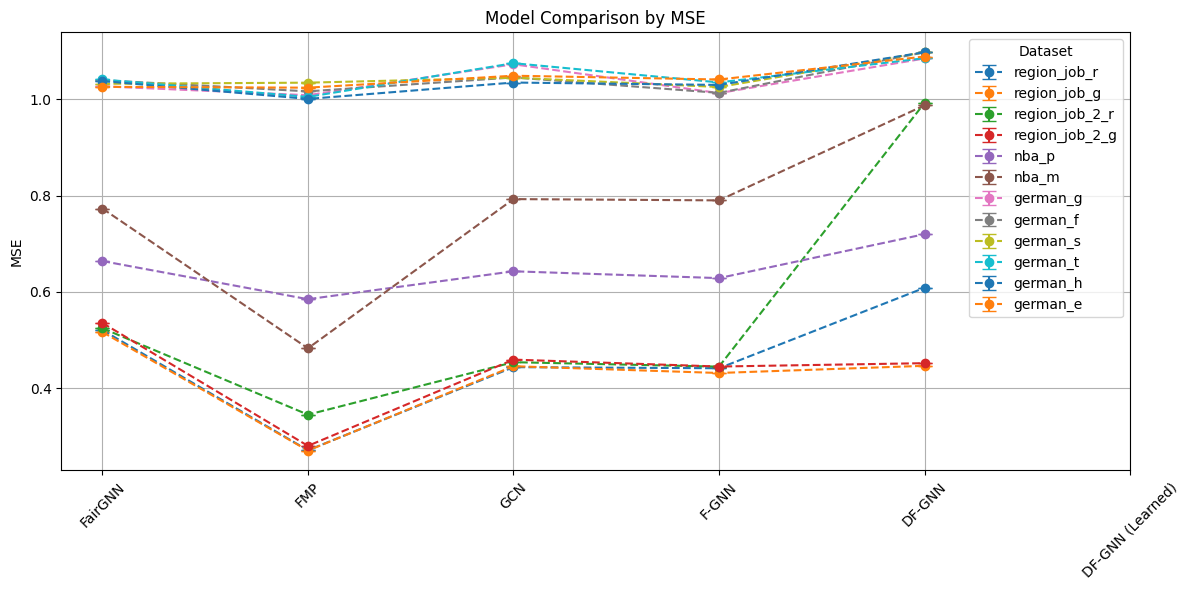

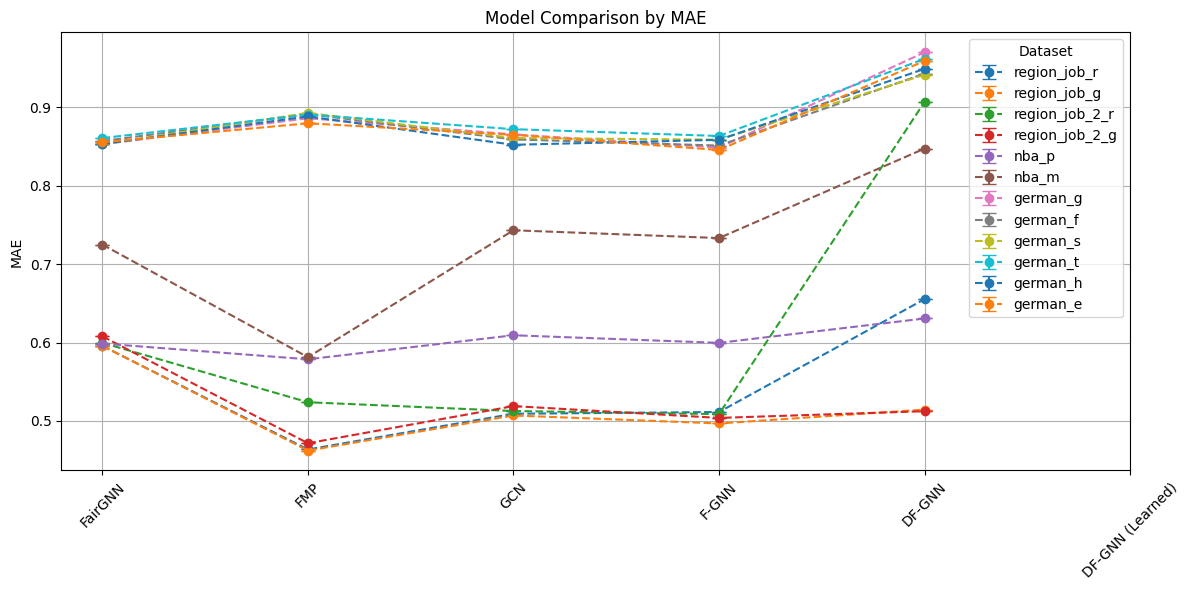

KeyError: 'MSE-diff Mean'

<Figure size 1200x600 with 0 Axes>

In [197]:
# metric 리스트와 모델, 데이터셋 목록 정의
metric_names = ['MSE', 'MAE', 'MSE-diff', 'Wasserstein', 'KL', 'JS', 'KS', 'CVM', 'TV']
models = ['FairGNN', 'FMP', 'GCN', 'F-GNN', 'DF-GNN', 'DF-GNN (Learned)']
datasets = df['Dataset'].unique()

# 지표별로 모델별 평균 + 표준편차 시각화
for metric in metric_names:
    plt.figure(figsize=(12, 6))
    
    for ds in datasets:
        df_ds = df[df['Dataset'] == ds]
        means, stds = [], []
        
        for model in models:
            row = df_ds[df_ds['Model'] == model]
            if not row.empty:
                means.append(row[f'{metric} Mean'].values[0])
                stds.append(row[f'{metric} Std'].values[0])
            else:
                means.append(np.nan)
                stds.append(0)  # 시각화 시 결측은 0으로 처리
        
        x = np.arange(len(models))
        plt.errorbar(x, means, yerr=stds, label=ds, capsize=5, marker='o', linestyle='--')
    
    plt.xticks(ticks=np.arange(len(models)), labels=models, rotation=45)
    plt.ylabel(metric)
    plt.title(f'Model Comparison by {metric}')
    plt.legend(title='Dataset')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


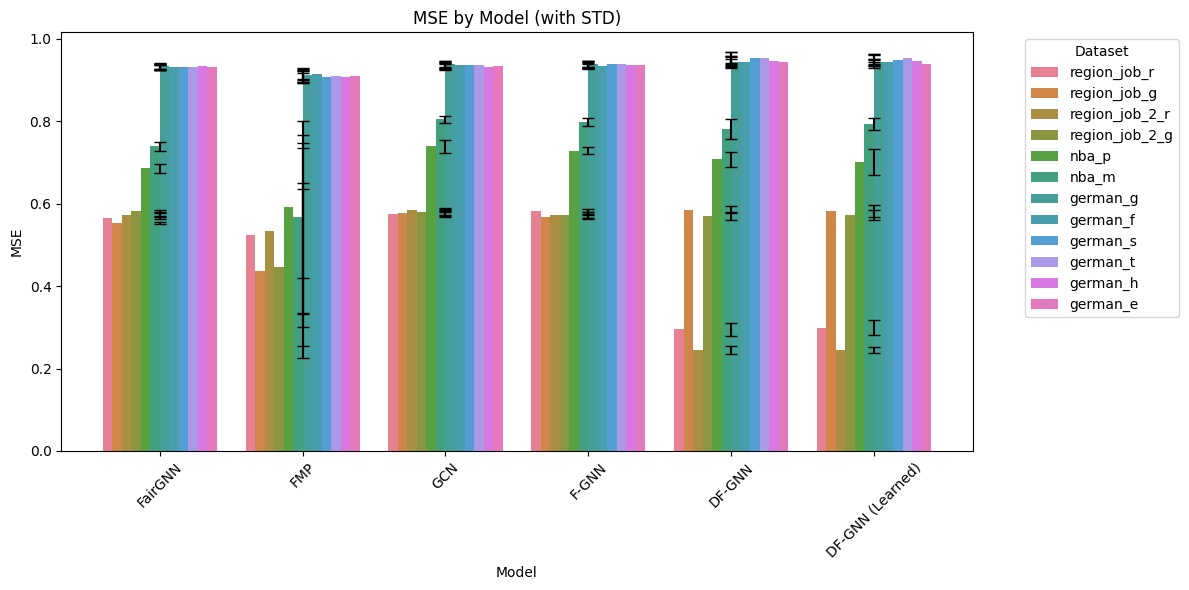

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


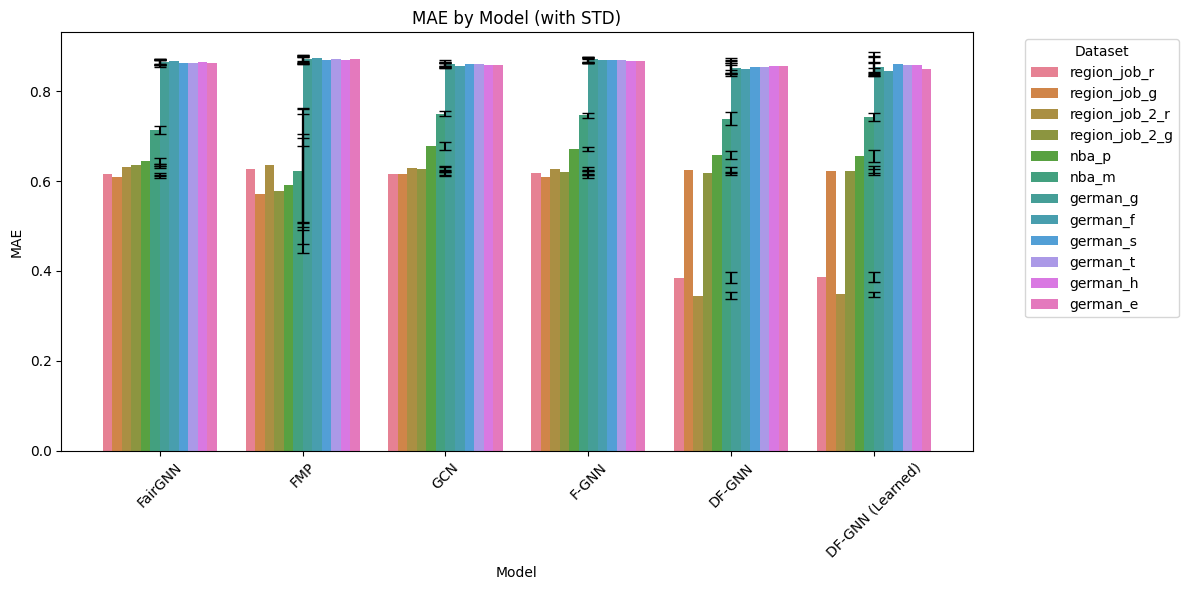

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


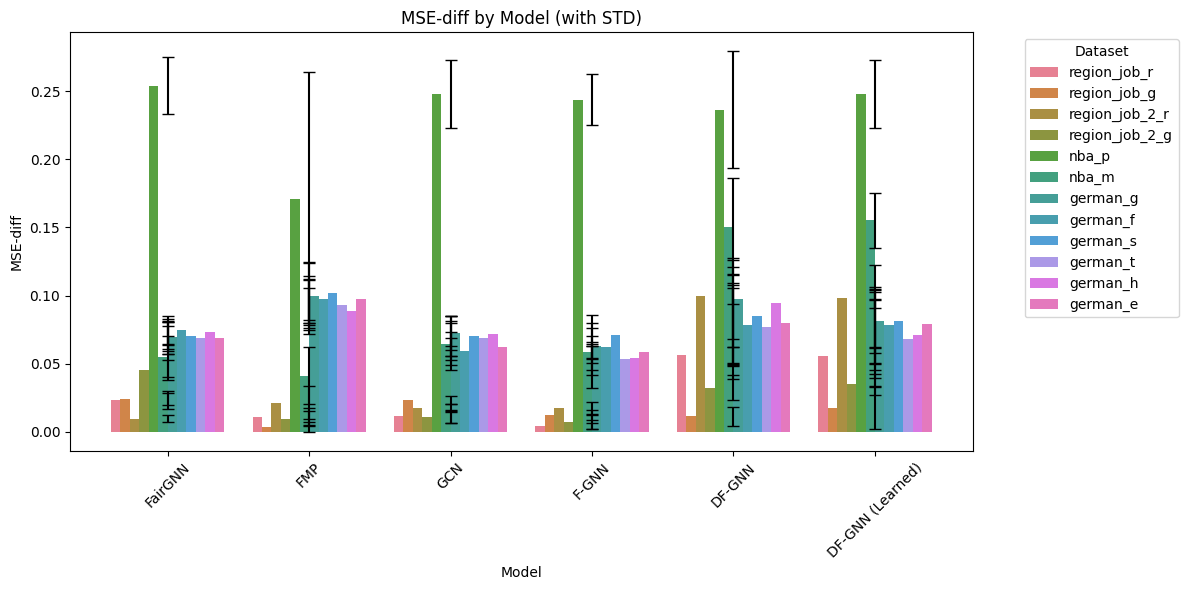

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


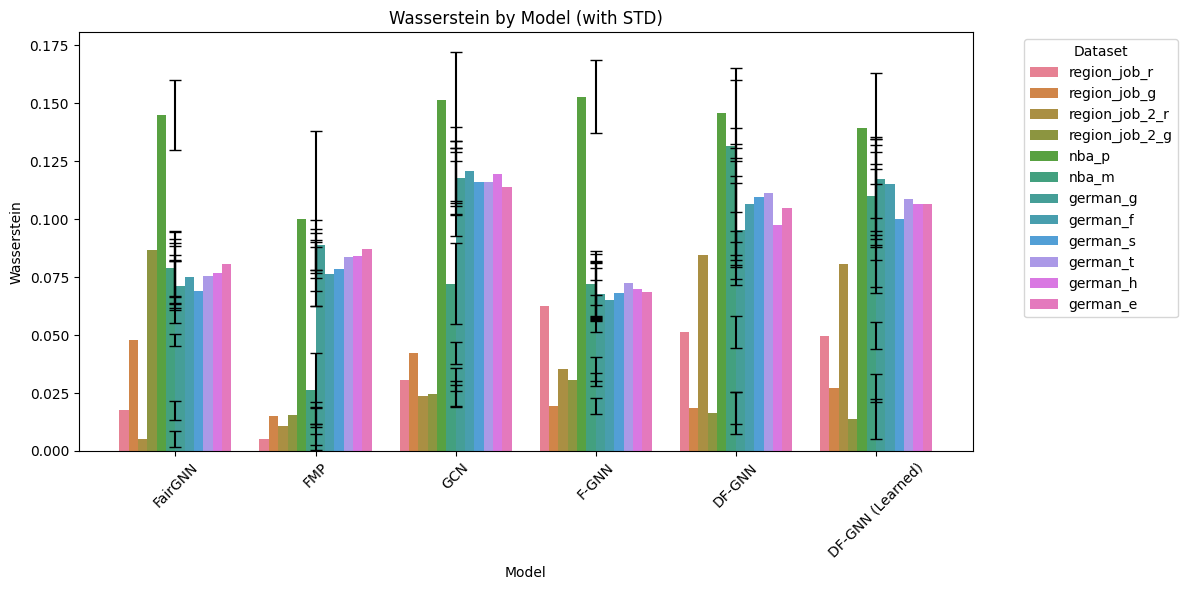

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


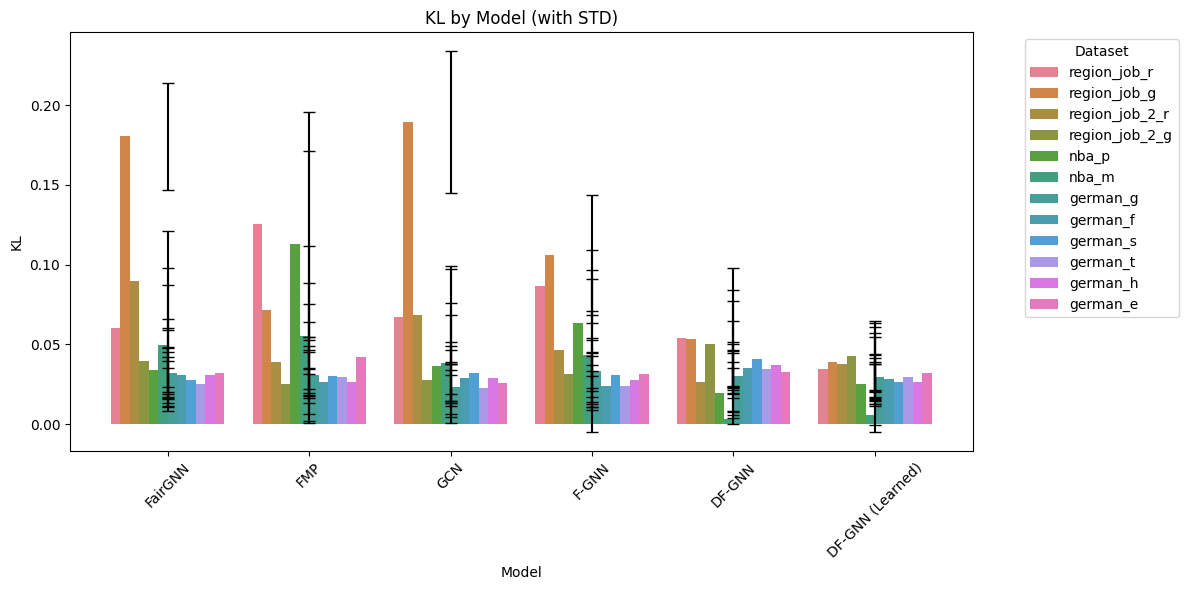

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


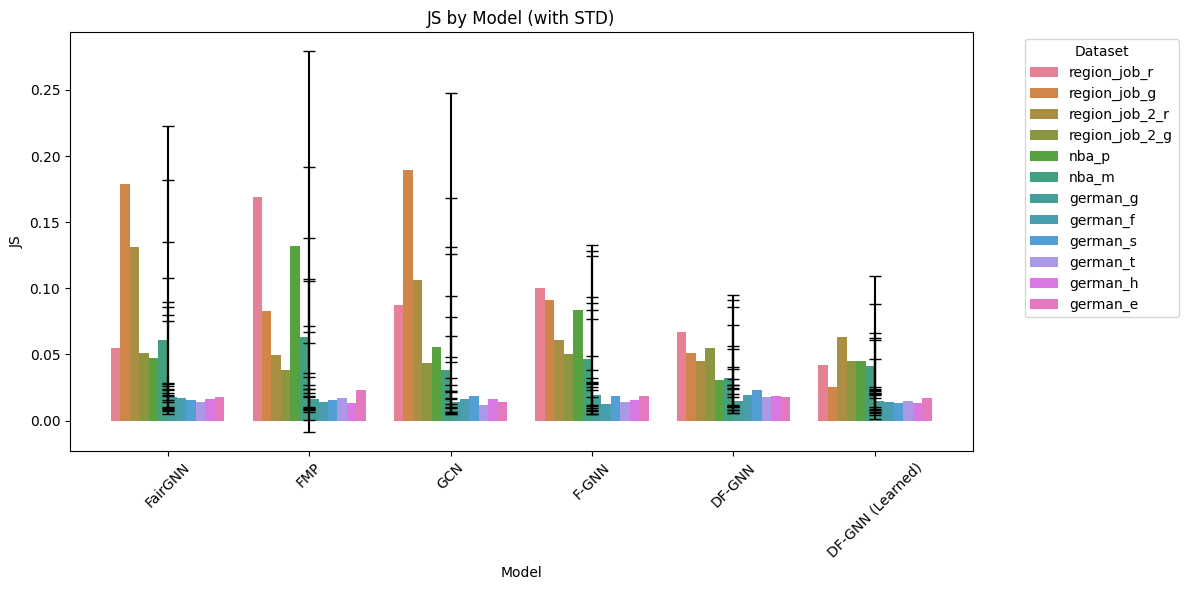

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


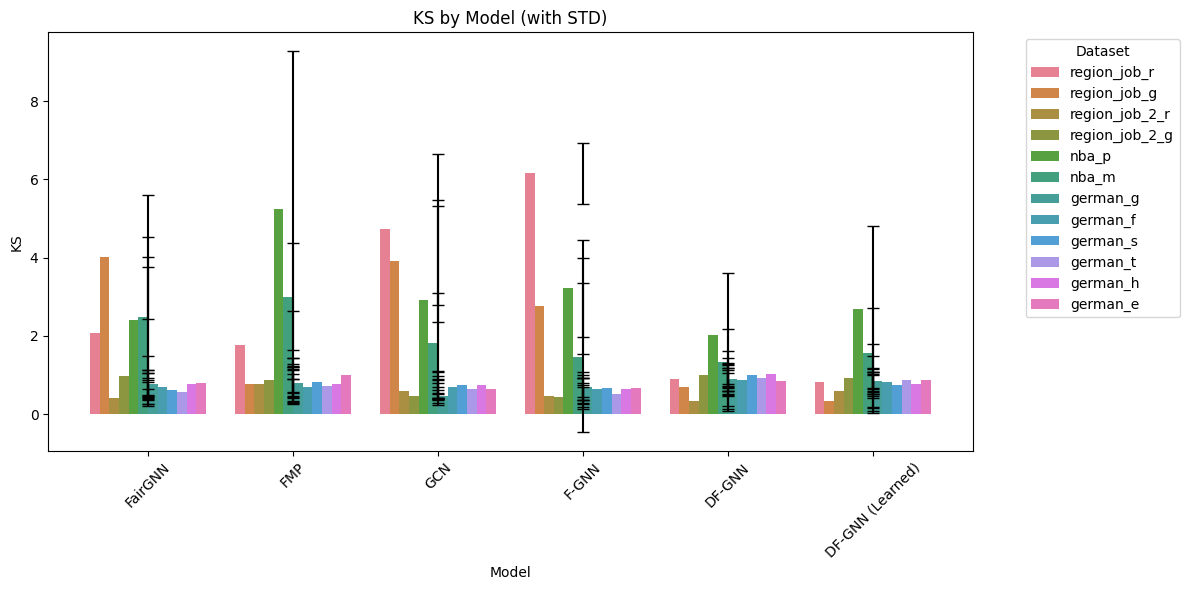

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


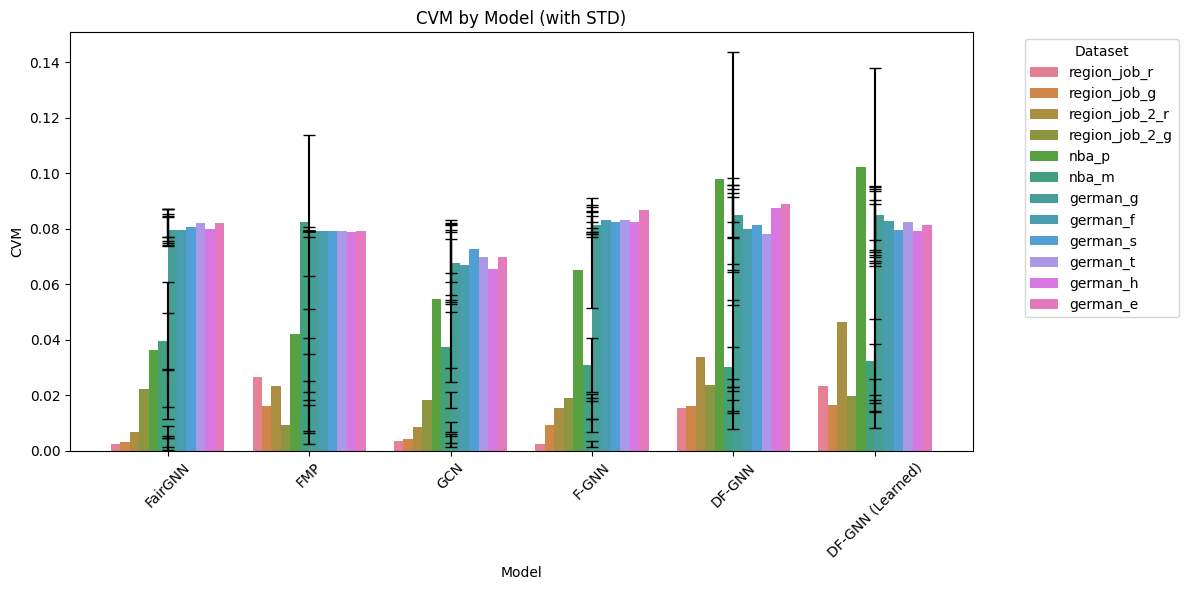

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


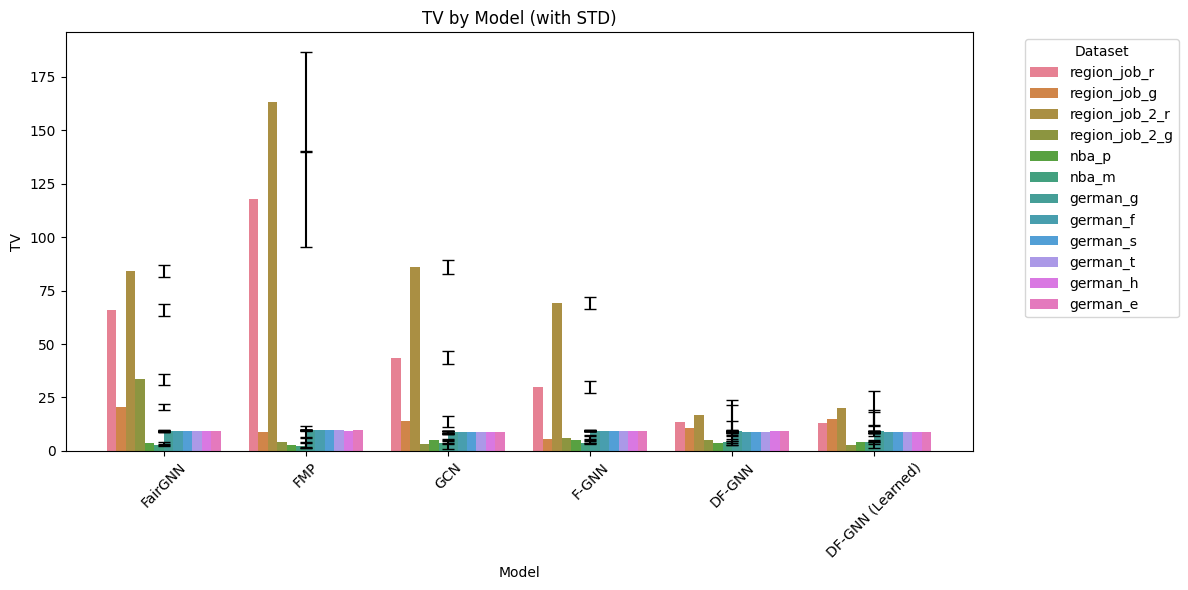

In [77]:
for metric in metric_names:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df, x="Model", y=f"{metric} Mean", hue="Dataset",
        ci=None, capsize=0.1
    )
    for i, row in df.iterrows():
        plt.errorbar(
            x=i % len(models), 
            y=row[f"{metric} Mean"], 
            yerr=row[f"{metric} Std"], 
            fmt='none', c='black', capsize=4
        )
    plt.title(f'{metric} by Model (with STD)')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

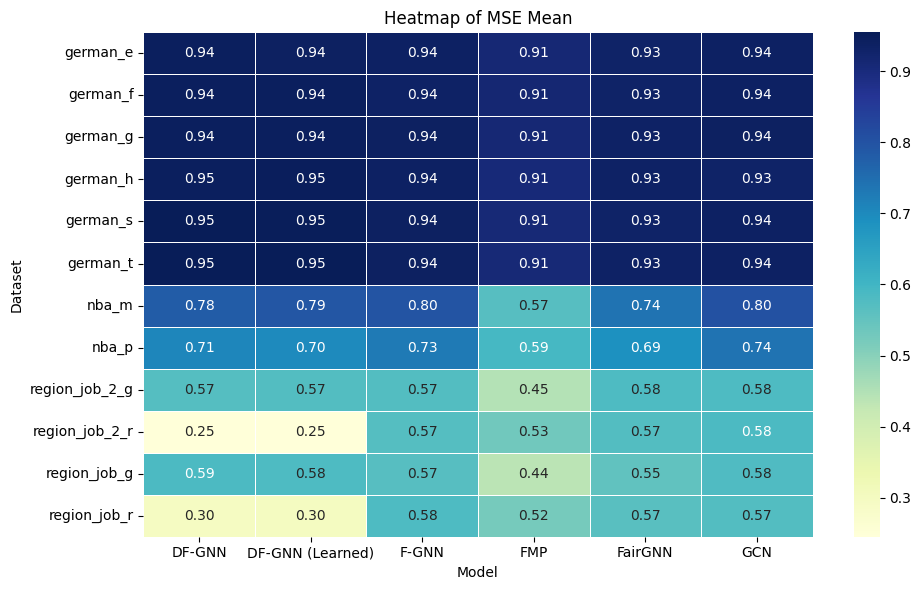

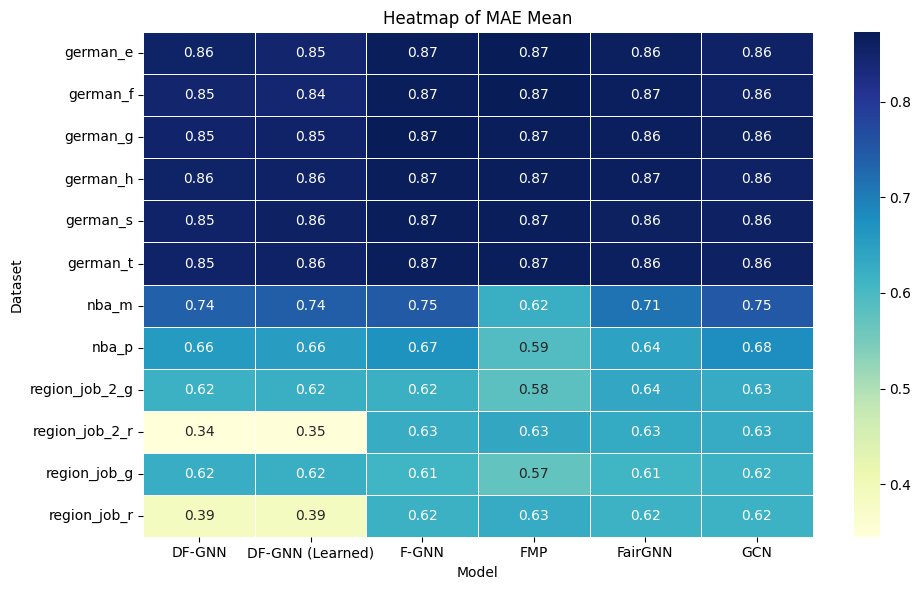

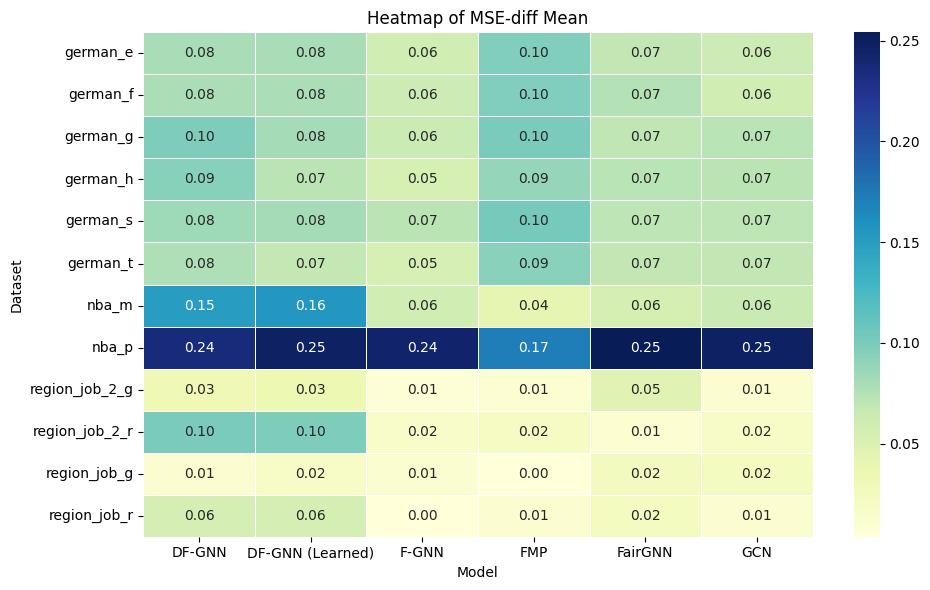

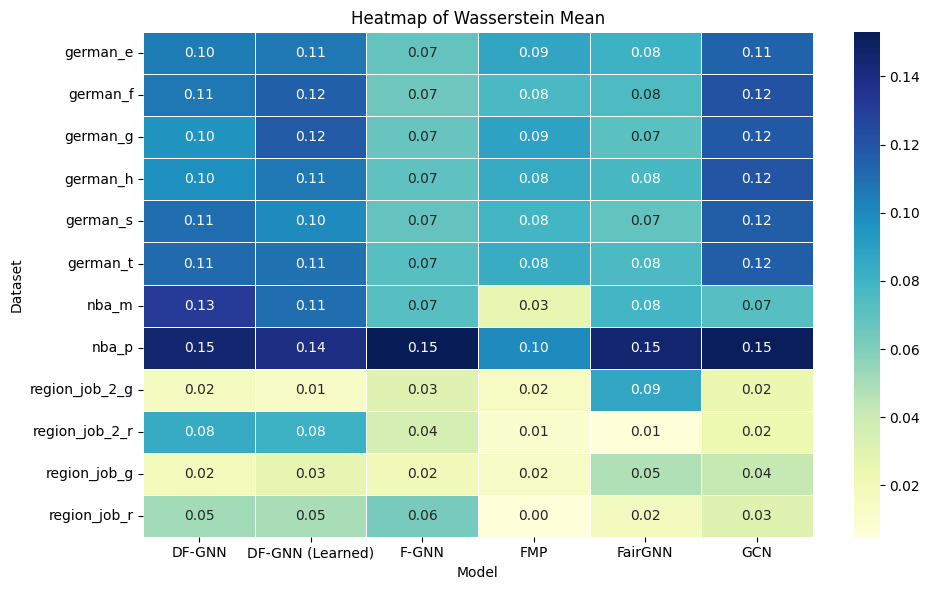

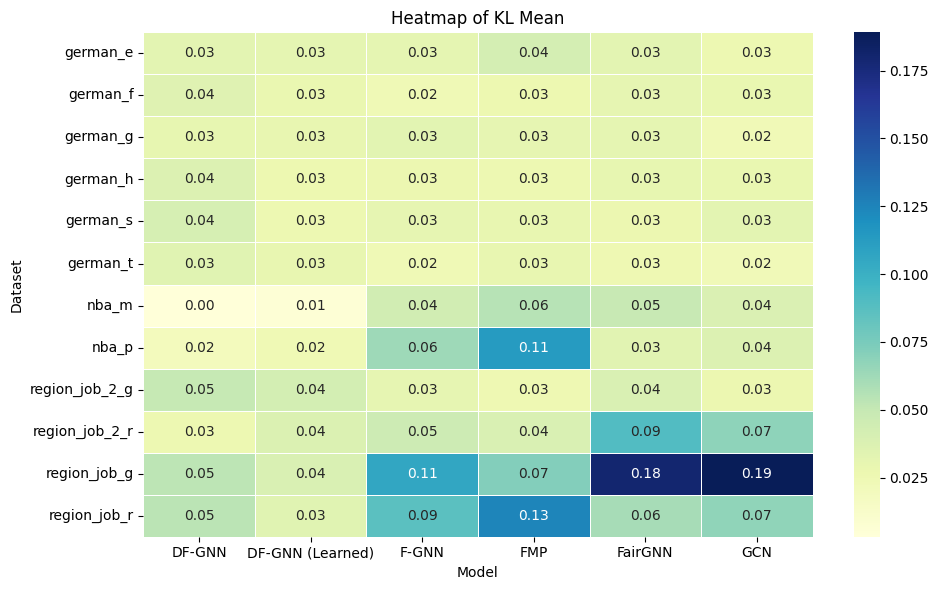

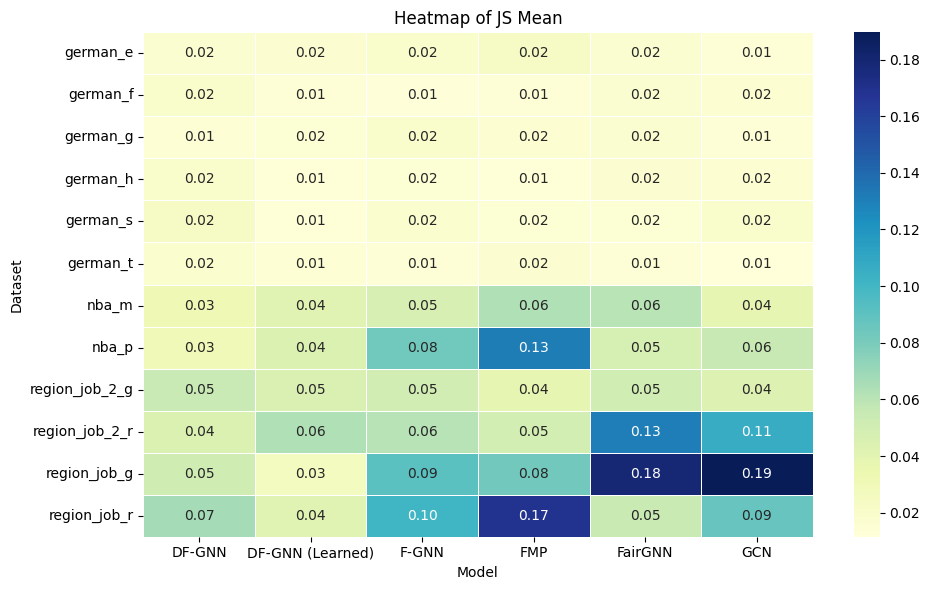

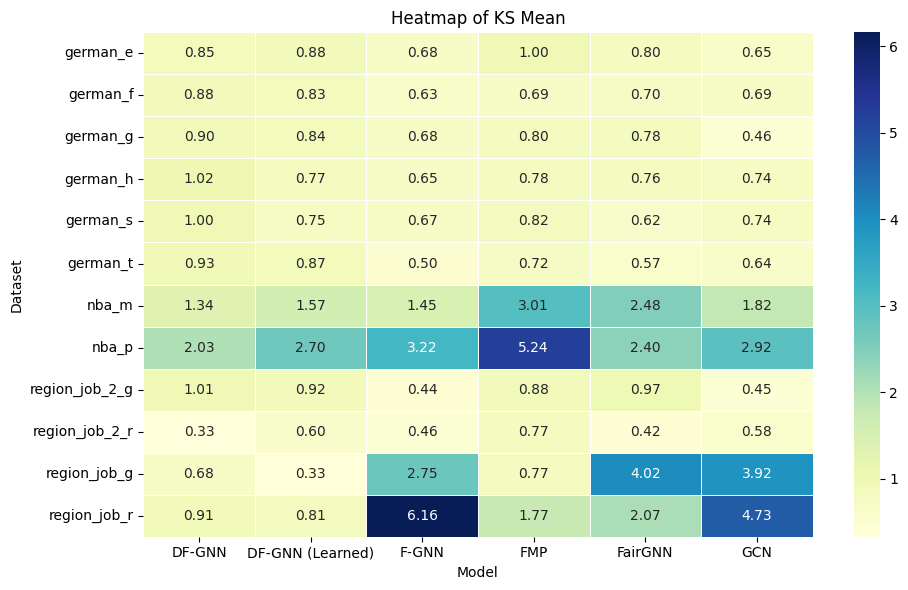

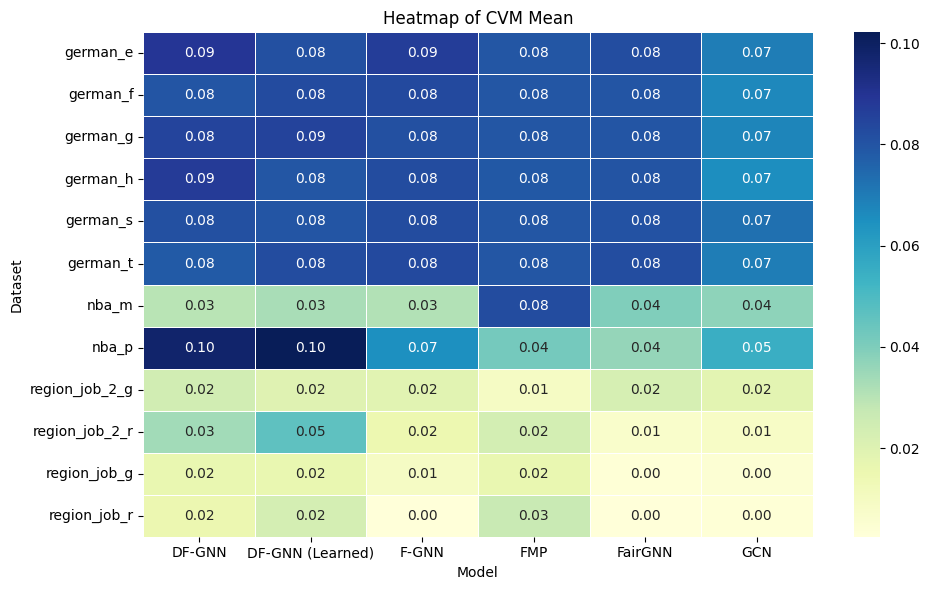

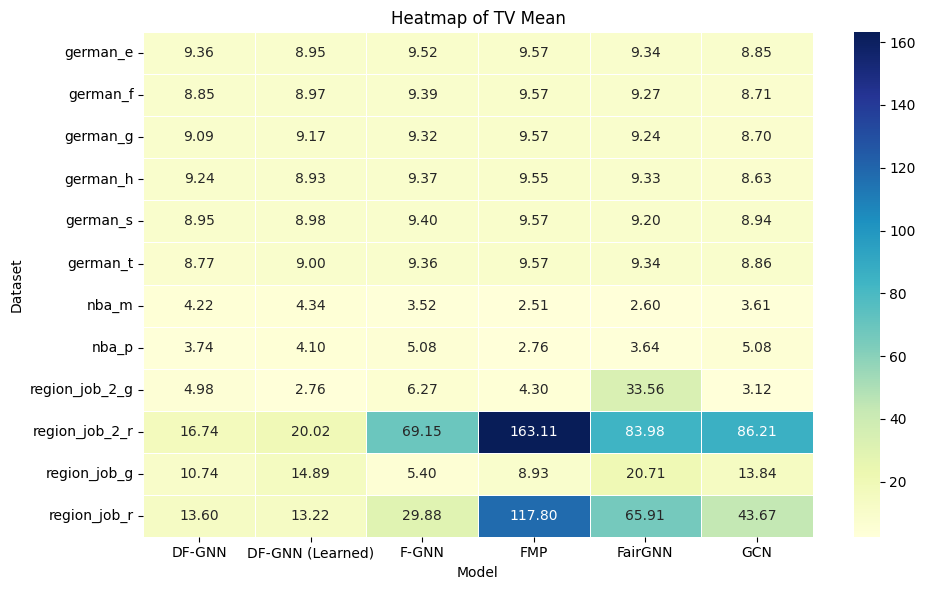

In [78]:
for metric in metric_names:
    pivot_table = df.pivot(index='Dataset', columns='Model', values=f'{metric} Mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Heatmap of {metric} Mean')
    plt.ylabel("Dataset")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

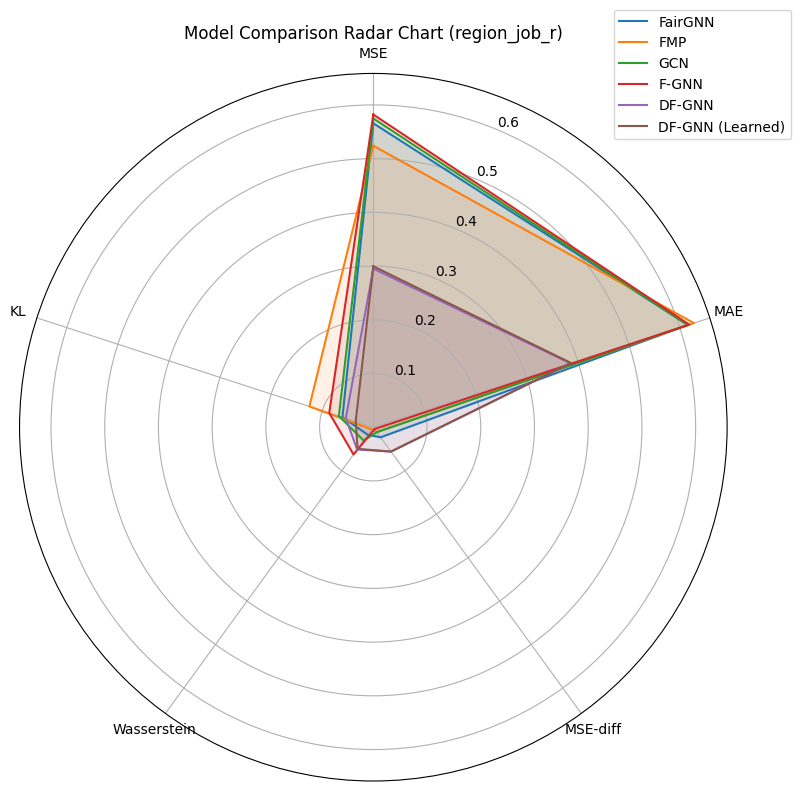

In [79]:
from math import pi

def plot_radar_chart(df, dataset):
    df_ds = df[df['Dataset'] == dataset]
    metrics = metric_names[:5]  # 일부 지표만 보기 좋게 선택
    labels = models
    num_vars = len(metrics)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Loop back to start

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in labels:
        row = df_ds[df_ds['Model'] == model]
        if not row.empty:
            values = [row[f'{m} Mean'].values[0] for m in metrics]
            values += values[:1]  # Loop
            ax.plot(angles, values, label=model)
            ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metrics)
    plt.title(f'Model Comparison Radar Chart ({dataset})')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar_chart(df, dataset="region_job_r")  # 원하는 데이터셋으로 변경
